#### Imports

In [25]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns
import plotly.offline as pyoff
import plotly.graph_objs as go
import matplotlib.cm as cm
import warnings
warnings.filterwarnings('ignore')

from __future__ import division
from chart_studio import plotly
from sklearn.datasets import load_iris
from sklearn.cluster import DBSCAN
from scipy import stats
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from datetime import datetime, timedelta
from sklearn.manifold import TSNE
from pandas_profiling import ProfileReport
from sklearn import metrics


## K-Means Clustering

**Unsupervised Machine Learning** that uses multiple iterations to segment the unlabeled data points into K's different clusters in a way that each data point belongs to only a single group that has similar properties.

**Distance-based clustering** groups the points into some number of clusters such that distances within the cluster should be small while distances between clusters should be large.

<img src="https://miro.medium.com/max/1400/1*I98_jWkZDllTYNNzpCDehg.png"
    style="width:400px; float: center;"></img>

K-means uses **Euclidean distance** as a distance metric to calculate the distance between each point and the centroid.

## 1.1 RFM
<img src="https://miro.medium.com/max/1400/1*AUUc9RE9kEschoxlsFK1SQ.png"
    style="width:400px; float: center;"></img>

Group customers based on their transactional history:

- **1. Recency** (days_since_last_buy) 
- **2. Frequency** (num_orders)
- **3. Monetary Value** (product_net_amount_sum) 


Theoretically we will have segments like below:

- **Low Value:** Customers who are less active than others, not very frequent buyer/visitor and generates very low revenue.
- **Mid Value:** In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
- **High Value:** The group we don’t want to lose. High Revenue, Frequency and low Inactivity.

**The Goal** is to increase retention rate, you can do a segmentation based on churn probability.

### RFM: 6 months

In [117]:
df = pd.read_csv('df_users.csv')
df_cluster = df[['CustomerUniqueIdEmailHash', 'num_orders', 'product_net_amount_sum','days_since_last_buy']]
df_cluster.rename(columns = {'CustomerUniqueIdEmailHash':'Customer','num_orders':'Frequency','product_net_amount_sum':'Monetary','days_since_last_buy':'Recency'}, inplace=True)
df_cluster

Customer  Frequency  Monetary  Recency
0      00029736b495db897a94099c5378a6c0ac76e288          1     39.03        7
1      00031ac41eb5b21be5b4fbc1d50dd43948e01357          1    107.77       90
2      00035cffce191437bd00adea61d73a346b3965d5          1     19.05        8
3      0003dfdcbabb0a33168e9b5b09b1f08fb0a960f9          1     14.46       84
4      00056521f6daa362ea4b49a3dfaff7e6433edb60          1     17.45       38
...                                         ...        ...       ...      ...
84519  fffdaf75cbff98b85a4c53a3866900ba4bf1d9dd          1     13.47       48
84520  fffdb706d9f994e5732b6dd85bc4b181a5d3cda1          1      2.31      152
84521  fffdb9bcceac96a27529fb2b46a6a4f9c0b7c5c6          1    227.20      126
84522  fffe3332824df69941cd74912548aeb74c10c9cf          1    129.90       32
84523  fffe603af1b9d46985202f19d85730fb93af827d          2    405.75       20

[84524 rows x 4 columns]

### k-means is not able to deal with missing values. 
The plot confirm that are not missing values on features

Text(0.5, 1.0, 'Missing value in the dataset')

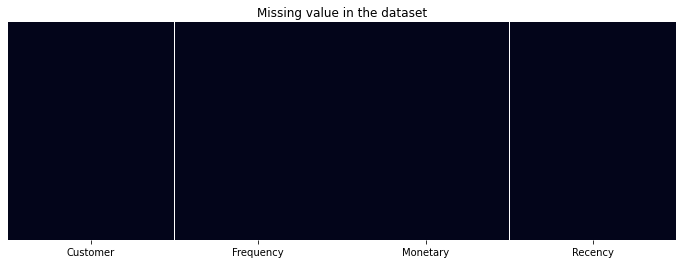

In [27]:
plt.figure(figsize=(12,4))
sns.heatmap(df_cluster.isnull(),cbar=False,cmap='rocket',yticklabels=False)
plt.title('Missing value in the dataset')

Quantity of missing values

In [28]:
#6 months
df_cluster.isnull().sum()

Customer     0
Frequency    0
Monetary     0
Recency      0
dtype: int64

### K-means gives the best result under the following conditions:

- Data’s distribution is not skewed
- Data is standardised (i.e. mean of 0 and standard deviation of 1).

Let’s find the skewness in our data

**Function:**

In [29]:
## Function to check skewness
def check_skew(df_skew, column):
    skew = stats.skew(df_skew[column])
    skewtest = stats.skewtest(df_skew[column])
    plt.title('Distribution of ' + column)
    sns.distplot(df_skew[column])
    print("{}'s: Skew: {}, : {}".format(column, skew, skewtest))
    return

The data is **highly skewed**, therefore we will perform **log transformations** to reduce the skewness of each variable. 

Recency's: Skew: 0.4109434206714185, : SkewtestResult(statistic=46.92479001853298, pvalue=0.0)
Frequency's: Skew: 29.215689398911998, : SkewtestResult(statistic=413.9604445773128, pvalue=0.0)
Monetary's: Skew: 38.66815200460616, : SkewtestResult(statistic=441.12324518082556, pvalue=0.0)


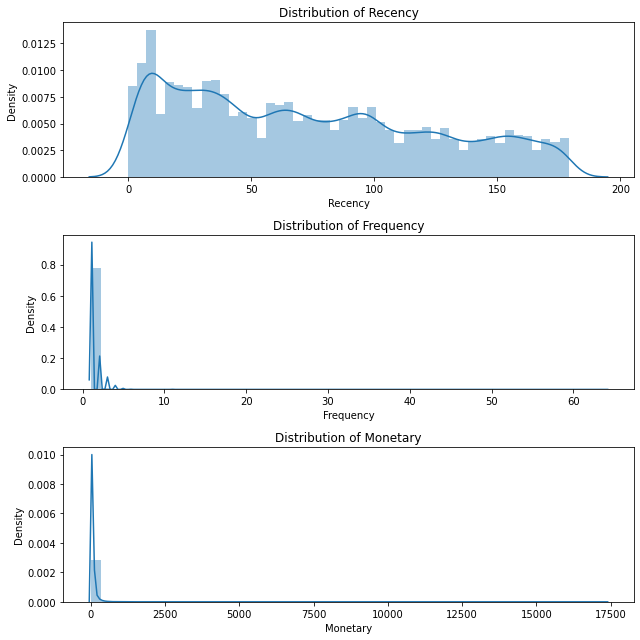

In [30]:
#3 plots of skewness
plt.figure (figsize=(9,9))

#Recency
plt.subplot(3,1,1)
check_skew(df_cluster, 'Recency')

#Frequency
plt.subplot(3,1,2)
check_skew(df_cluster, 'Frequency')

#Monetary
plt.subplot(3,1,3)
check_skew(df_cluster, 'Monetary')

plt.tight_layout()
plt.show()

Recency's: Skew: -1.1481875393455188, : SkewtestResult(statistic=-110.64669949437982, pvalue=0.0)
Frequency's: Skew: 4.411060058773685, : SkewtestResult(statistic=231.503678763704, pvalue=0.0)
Monetary's: Skew: 0.3669472814523448, : SkewtestResult(statistic=42.21011907103483, pvalue=0.0)


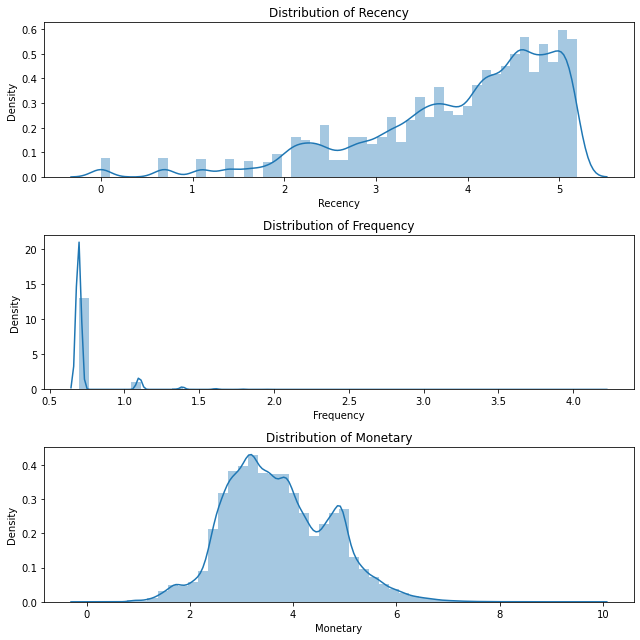

In [31]:
#Removing Skewness
df_rfm_log = np.log(df_cluster[['Frequency','Monetary','Recency']]+1)
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(df_rfm_log,'Recency')
plt.subplot(3, 1, 2)
check_skew(df_rfm_log,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log,'Monetary')
plt.tight_layout()

After the skewness is reduced, the data is standardised by centring and scaling.

In [32]:
scaler = StandardScaler()
scaler.fit(df_rfm_log)
RFM_Table_scaled = scaler.transform(df_rfm_log)

#dataframe
RFM_Table_scaled = pd.DataFrame(RFM_Table_scaled, columns=df_rfm_log.columns)
RFM_Table_scaled.head()

Frequency  Monetary   Recency
0  -0.293195 -0.021803 -1.739744
1  -0.293195  0.977119  0.573471
2  -0.293195 -0.712730 -1.627687
3  -0.293195 -0.972525  0.508578
4  -0.293195 -0.795837 -0.232636

In [33]:
RFM_Table_scaled.describe()

Frequency      Monetary       Recency
count  8.452400e+04  8.452400e+04  8.452400e+04
mean  -3.077416e-15 -1.007612e-16 -8.776415e-17
std    1.000006e+00  1.000006e+00  1.000006e+00
min   -2.931947e-01 -3.698962e+00 -3.718093e+00
25%   -2.931947e-01 -7.293140e-01 -5.144985e-01
50%   -2.931947e-01 -1.159750e-01  2.678814e-01
75%   -2.931947e-01  7.112343e-01  7.710158e-01
max    2.098611e+01  6.046003e+00  1.222408e+00

### Finding the optimal number of clusters with Elbow Method

`Elbow Method` simply tells the optimal cluster number, because a different number of clusters can lead us to completely different results.

The idea behind e`Elbow Method` is to run k-means clustering on a given dataset for a range of values of k (num_clusters, e.g k=1 to 10), and for each value of k, calculate sum of squared errors (SSE).

**SSE tends to decrease toward 0 as we increase k** (and SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

**The goal** is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.



**Function:**

Elbow plot shows at what value of k, the distance between the mean of a cluster and the other data points in the cluster is at its lowest

In [34]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled) 
    kmeanModel.fit(RFM_Table_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

`Inertia` is the sum of squared distances of samples to their closest cluster centre.

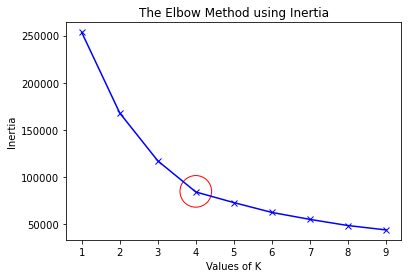

In [35]:
plt.plot(K, inertias, 'bx-')
plt.scatter( 4 , 84734.02534740775 , s=1000 ,  facecolors='none', edgecolors='red' ) 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

The optimal number of cluster can be any number between 4 upto 7.

In [36]:
SED = mapping2
SED

{1: 253571.99999999878,
 2: 167937.31095915532,
 3: 117167.96645439856,
 4: 84102.42336012152,
 5: 72830.77550434202,
 6: 62388.14631699008,
 7: 55009.47041728247,
 8: 48471.77508956199,
 9: 43837.73832556341}

### Visualize Clusters

In [37]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    plt.xlabel('X axis of flattened normalized clusters')
    plt.ylabel('Y axis of flattened normalized clusters')
    
    return df_new

#### 2D Plot

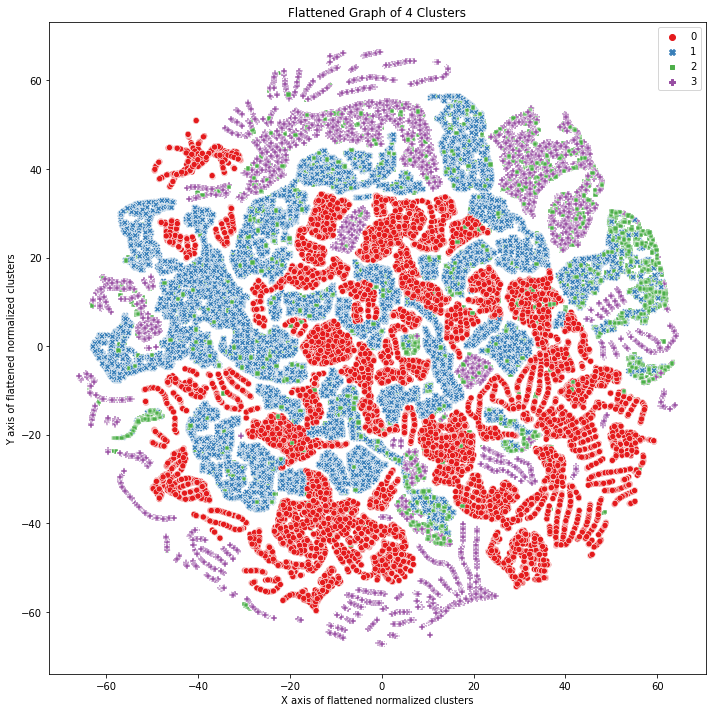

In [38]:
#Data set
RFM_cluster = df_cluster[['Frequency','Monetary','Recency']]

plt.figure(figsize=(10, 10))
df_rfm_k4 = kmeans(RFM_Table_scaled, 4, RFM_cluster)
plt.tight_layout()

Flattening three-dimensional graphs (created from Recency, Frequency, and MonetaryValue) into two-dimensional graphs for ease of visualisation. The technique for flattening high dimensional graph and visualising it in a two-dimensional format is known as **t-Distributed Stochastic Neighbor Embedding**.

#### 3D Plot - Original Data Frame

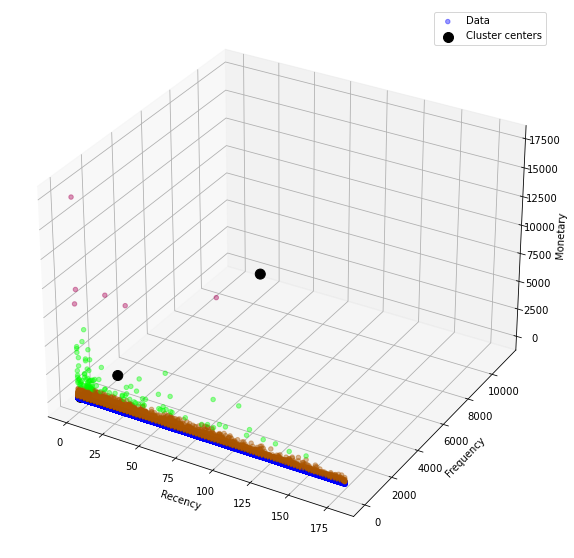

In [39]:
from mpl_toolkits.mplot3d import Axes3D

k = 4
kmeans = KMeans(n_clusters = k, random_state = 1).fit(RFM_cluster)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(RFM_cluster.Recency, RFM_cluster.Frequency, RFM_cluster.Monetary, c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c = 'black', s=100, alpha=1)
plt.legend(['Data','Cluster centers'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

#### 3D Plot - Standardized Data Frame

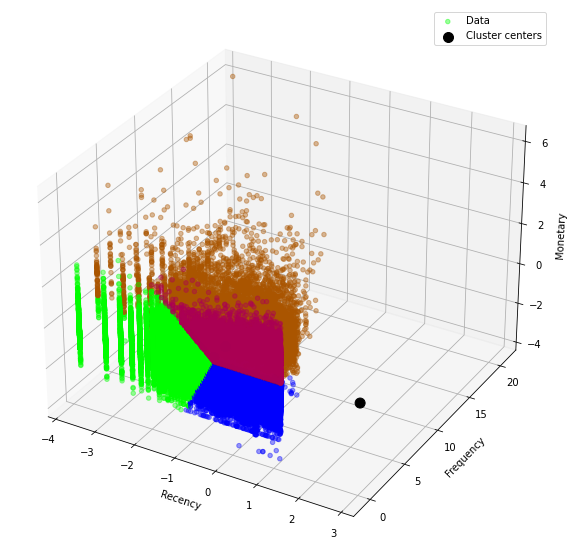

In [103]:
from mpl_toolkits.mplot3d import Axes3D

k = 4
kmeans = KMeans(n_clusters = k, random_state = 1).fit(RFM_Table_scaled)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(RFM_Table_scaled.Recency, RFM_Table_scaled.Frequency, RFM_Table_scaled.Monetary, c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c = 'black', s=100, alpha=1)
plt.legend(['Data','Cluster centers'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

#### Snake Plot

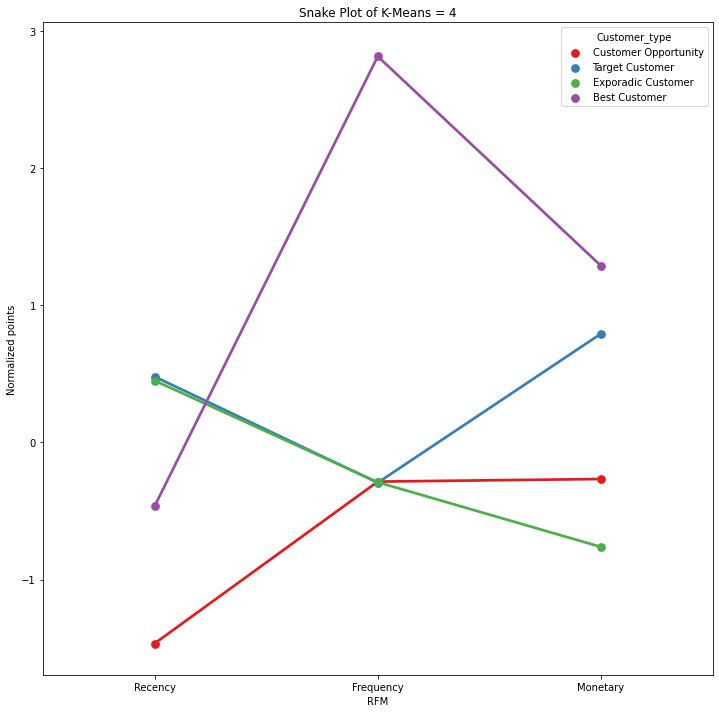

In [110]:
#df
df_rfm_k4['Customer_type'] = df_rfm_k4['Cluster']
df_rfm_k4['Customer_type'].replace({3:'Customer Opportunity',2:'Best Customer',1:'Target Customer',0:'Exporadic Customer'}, inplace=True)



def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm_original.index, 
                                       columns=df_rfm_original.columns)
    normalised_df_rfm['Customer_type'] = df_rfm_kmeans['Customer_type']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['Customer', 'Customer_type'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='RFM', 
                        value_name='Normalized points')
    plt.xlabel('RFM')
    plt.ylabel('Normalized points')
    sns.pointplot(data=df_melt, x='RFM', y='Normalized points', hue='Customer_type',errwidth=0, palette='Set1')
    
    return

plt.figure(figsize=(12, 12))
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled, df_rfm_k4, df_cluster)

#### Interpretation

- **Customer Opportunity**: Consolidade as a customer
        - High Recency, a great opportunity to consolidate as a customer.
        - Low Frequency, recently bought a product, so the frequency will be low 
        - Medium Monetary

- **Best Customer**: Cannot lose the client
        - High Recency, bought recently.
        - High Frequency, frequently buyer 
        - Hgih Monetary, spend more than the average customers

- **Target Customer**: Work hard to be a closer client
        - Low Recency, a great opportunity to consolidate as a customer.
        - Medium Frequency, recently bought a product, so the frequency will be low 
        - High Monetary

- **Exporadic Customer**: Everything from here is a bonus.
        - Low Recency, a great opportunity to consolidate as a customer.
        - Low Frequency, recently bought a product, so the frequency will be low 
        - Low Monetary

In [111]:
def rfm_values(df):

    df_new = df.groupby(['Customer_type','Cluster']).agg({
        'Recency': ['mean','median'],
        'Frequency': ['mean','median'],
        'Monetary': ['mean','median','count']
    }).round(2)
    
    return df_new

rfm_values(df_rfm_k4)

Recency        Frequency        Monetary          \
                                mean median      mean median     mean  median   
Customer_type        Cluster                                                    
Best Customer        2         47.24     36      2.44      2   236.65  148.43   
Customer Opportunity 3         12.55     11      1.00      1    43.33   27.78   
Exporadic Customer   0         90.20     86      1.00      1    20.47   19.63   
Target Customer      1         93.91     91      1.00      1   105.83   85.68   

                                     
                              count  
Customer_type        Cluster         
Best Customer        2         7897  
Customer Opportunity 3        16514  
Exporadic Customer   0        34383  
Target Customer      1        25730

#### Evaluation

In [47]:
# Transformations
df_6m=pd.merge(df_cluster,df_rfm_k4, right_index=True, left_index=True)
df_6m=df_6m[['Customer', 'Frequency_x', 'Monetary_x', 'Recency_x', 'Cluster']]
df_6m.rename(columns ={'Customer':'Customer','Frequency_x':'Frequency','Monetary_x':'Monetary','Recency_x':'Recency'}, inplace=True)

# Data Frame
df_6m['Customer_type'] = df_6m['Cluster']
df_6m['Customer_type'].replace({3:'Customer Opportunity',2:'Best Customer',1:'Targ et Customer',0:'Exporadic Customer'}, inplace=True)
df_6m

Customer  Frequency  Monetary  Recency  \
0      00029736b495db897a94099c5378a6c0ac76e288          1     39.03        7   
1      00031ac41eb5b21be5b4fbc1d50dd43948e01357          1    107.77       90   
2      00035cffce191437bd00adea61d73a346b3965d5          1     19.05        8   
3      0003dfdcbabb0a33168e9b5b09b1f08fb0a960f9          1     14.46       84   
4      00056521f6daa362ea4b49a3dfaff7e6433edb60          1     17.45       38   
...                                         ...        ...       ...      ...   
84519  fffdaf75cbff98b85a4c53a3866900ba4bf1d9dd          1     13.47       48   
84520  fffdb706d9f994e5732b6dd85bc4b181a5d3cda1          1      2.31      152   
84521  fffdb9bcceac96a27529fb2b46a6a4f9c0b7c5c6          1    227.20      126   
84522  fffe3332824df69941cd74912548aeb74c10c9cf          1    129.90       32   
84523  fffe603af1b9d46985202f19d85730fb93af827d          2    405.75       20   

       Cluster         Customer_type  
0            3  Customer Opportunity  
1            1      Targ et Customer  
2            3  Customer Opportunity  
3            0    Exporadic Customer  
4            0    Exporadic Customer  
...        ...                   ...  
84519        0    Exporadic Customer  
84520        0    Exporadic Customer  
84521        1      Targ et Customer  
84522        1      Targ et Customer  
84523        2         Best Customer  

[84524 rows x 6 columns]

---------

### RFM: 1 year

In [173]:
df_1y = pd.read_csv('df_users_1y.csv')
df_1y

CustomerUniqueIdEmailHash  num_orders country  \
0       0000179956ad470b814e96c6c9f47b0faefcf4b0           1      CL   
1       00029736b495db897a94099c5378a6c0ac76e288           1      GB   
2       00031ac41eb5b21be5b4fbc1d50dd43948e01357           3      GB   
3       00035cffce191437bd00adea61d73a346b3965d5           1      DE   
4       0003816b0a2a45fd62432a602f73485e5e6a6c2d           1      BR   
...                                          ...         ...     ...   
139541  fffdaf75cbff98b85a4c53a3866900ba4bf1d9dd           1      US   
139542  fffdb706d9f994e5732b6dd85bc4b181a5d3cda1           1      FR   
139543  fffdb9bcceac96a27529fb2b46a6a4f9c0b7c5c6           1      SG   
139544  fffe3332824df69941cd74912548aeb74c10c9cf           1      SA   
139545  fffe603af1b9d46985202f19d85730fb93af827d           4      AU   

       payment_method order_carrier  order_shipping_price_mean  \
0              stripe        ctbdhl                  15.460000   
1              paypal        ctbctt                   5.260000   
2              stripe        ctbdhl                   3.706667   
3       m2epropayment        ctbctt                   5.850000   
4               ebanx        ctbctt                   7.600000   
...               ...           ...                        ...   
139541         stripe        ctbctt                   4.460000   
139542         stripe        ctbctt                   2.980000   
139543         stripe        ctbdhl                   0.000000   
139544         stripe        ctbdhl                   0.000000   
139545         paypal        ctbdhl                   4.257500   

        order_shipping_price_sum  order_shipping_price_last  \
0                          15.46                      15.46   
1                           5.26                       5.26   
2                          11.12                       0.00   
3                           5.85                       5.85   
4                           7.60                       7.60   
...                          ...                        ...   
139541                      4.46                       4.46   
139542                      2.98                       2.98   
139543                      0.00                       0.00   
139544                      0.00                       0.00   
139545                     17.03                       0.00   

        product_qty_ordered_mean  product_qty_ordered_sum  ...  \
0                           3.00                      3.0  ...   
1                           3.00                      3.0  ...   
2                           3.00                      9.0  ...   
3                           3.00                      3.0  ...   
4                           1.00                      1.0  ...   
...                          ...                      ...  ...   
139541                      3.00                      3.0  ...   
139542                      1.00                      1.0  ...   
139543                      9.00                      9.0  ...   
139544                      9.00                      9.0  ...   
139545                      4.25                     17.0  ...   

        num_orders_15d  net_amount_15d  num_orders_30d  net_amount_30d  \
0                  0.0            0.00             0.0            0.00   
1                  1.0           39.03             1.0           39.03   
2                  0.0            0.00             0.0            0.00   
3                  1.0           19.05             1.0           19.05   
4                  0.0            0.00             0.0            0.00   
...                ...             ...             ...             ...   
139541             0.0            0.00             0.0            0.00   
139542             0.0            0.00             0.0            0.00   
139543             0.0            0.00             0.0            0.00   
139544             0.0            0.00             0.0            0.00   
1

In [49]:
#Dataframe
df_cluster_1y = df_1y[['CustomerUniqueIdEmailHash','num_orders','product_net_amount_sum','days_since_last_buy']]
#Rename
df_cluster_1y.rename(columns ={'CustomerUniqueIdEmailHash':'Customer','num_orders':'Frequency','product_net_amount_sum':'Monetary','days_since_last_buy':'Recency'}, inplace=True)
#Cluster
df_cluster_1y

Customer  Frequency  Monetary  Recency
0       0000179956ad470b814e96c6c9f47b0faefcf4b0          1     64.72      326
1       00029736b495db897a94099c5378a6c0ac76e288          1     39.03        7
2       00031ac41eb5b21be5b4fbc1d50dd43948e01357          3    282.76       90
3       00035cffce191437bd00adea61d73a346b3965d5          1     19.05        8
4       0003816b0a2a45fd62432a602f73485e5e6a6c2d          1     15.39      195
...                                          ...        ...       ...      ...
139541  fffdaf75cbff98b85a4c53a3866900ba4bf1d9dd          1     13.47       48
139542  fffdb706d9f994e5732b6dd85bc4b181a5d3cda1          1      2.31      152
139543  fffdb9bcceac96a27529fb2b46a6a4f9c0b7c5c6          1    227.20      126
139544  fffe3332824df69941cd74912548aeb74c10c9cf          1    129.90       32
139545  fffe603af1b9d46985202f19d85730fb93af827d          4    706.83       20

[139546 rows x 4 columns]

#### k-means is not able to deal with missing values. 
The plot confirm that are not missing values on features

Text(0.5, 1.0, 'Missing value in the dataset')

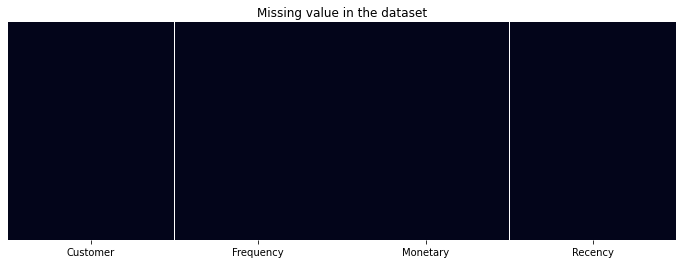

In [50]:
plt.figure(figsize=(12,4))
sns.heatmap(df_cluster_1y.isnull(),cbar=False,cmap='rocket',yticklabels=False)
plt.title('Missing value in the dataset')

In [51]:
#1 year
df_cluster_1y.isnull().sum()

Customer     0
Frequency    0
Monetary     0
Recency      0
dtype: int64

#### K-means gives the best result under the following conditions:

- Data’s distribution is not skewed
- Data is standardised (i.e. mean of 0 and standard deviation of 1).

Let’s find the skewness in our data

Recency's: Skew: 0.3355128816079724, : SkewtestResult(statistic=49.82973283389168, pvalue=0.0)
Frequency's: Skew: 31.732188699059755, : SkewtestResult(statistic=542.143191268286, pvalue=0.0)
Monetary's: Skew: 32.82130787658497, : SkewtestResult(statistic=546.344490647059, pvalue=0.0)


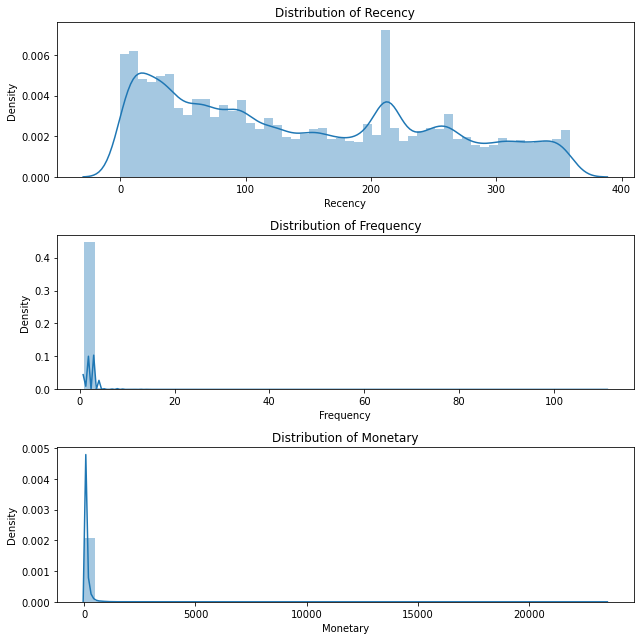

In [52]:
#3 plots of skewness
plt.figure (figsize=(9,9))

#Recency
plt.subplot(3,1,1)
check_skew(df_cluster_1y, 'Recency')

#Frequency
plt.subplot(3,1,2)
check_skew(df_cluster_1y, 'Frequency')

#Monetary
plt.subplot(3,1,3)
check_skew(df_cluster_1y, 'Monetary')

plt.tight_layout()
plt.show()

The data is **highly skewed**, therefore we will perform **log transformations** to reduce the skewness of each variable. 

Recency's: Skew: -1.20226351780389, : SkewtestResult(statistic=-146.86881071453166, pvalue=0.0)
Frequency's: Skew: 3.7348396215340016, : SkewtestResult(statistic=277.12373264916374, pvalue=0.0)
Monetary's: Skew: 0.4296435500190106, : SkewtestResult(statistic=62.82704013451245, pvalue=0.0)


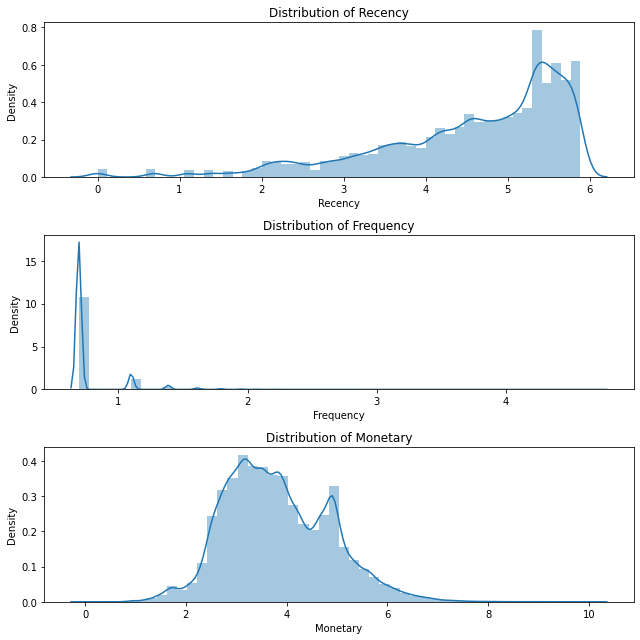

In [53]:
#Removing Skewness
df_rfm_log_1y = np.log(df_cluster_1y[['Frequency','Monetary','Recency']]+1)
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
check_skew(df_rfm_log_1y,'Recency')
plt.subplot(3, 1, 2)
check_skew(df_rfm_log_1y,'Frequency')
plt.subplot(3, 1, 3)
check_skew(df_rfm_log_1y,'Monetary')
plt.tight_layout()

After the skewness is reduced, the data is standardised by centring and scaling.

In [54]:
scaler = StandardScaler()
scaler.fit(df_rfm_log_1y)
RFM_Table_scaled_1y = scaler.transform(df_rfm_log_1y)

#dataframe
RFM_Table_scaled_1y = pd.DataFrame(RFM_Table_scaled_1y, columns=df_rfm_log.columns)
RFM_Table_scaled_1y.head()

Frequency  Monetary   Recency
0  -0.349072  0.359678  1.070233
1  -0.349072 -0.119261 -2.149609
2   2.908502  1.772733 -0.039720
3  -0.349072 -0.787183 -2.047402
4  -0.349072 -0.981896  0.626074

In [55]:
#1 year
RFM_Table_scaled_1y.describe()

Frequency      Monetary       Recency
count  1.395460e+05  1.395460e+05  1.395460e+05
mean  -1.705797e-15 -9.322035e-16  7.505434e-16
std    1.000004e+00  1.000004e+00  1.000004e+00
min   -3.490722e-01 -3.673987e+00 -3.954066e+00
25%   -3.490722e-01 -7.360425e-01 -5.421831e-01
50%   -3.490722e-01 -1.134864e-01  2.697882e-01
75%   -3.490722e-01  7.397411e-01  7.723977e-01
max    1.856882e+01  6.038566e+00  1.153663e+00

**Find optimal K**

In [56]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Table_scaled_1y) 
    kmeanModel.fit(RFM_Table_scaled_1y)     
      
    distortions.append(sum(np.min(cdist(RFM_Table_scaled_1y, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Table_scaled_1y.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Table_scaled_1y, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Table_scaled_1y.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

`Inertia` is the sum of squared distances of samples to their closest cluster centre.

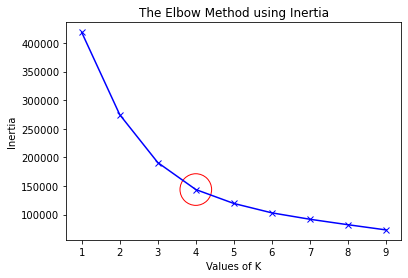

In [57]:
plt.plot(K, inertias, 'bx-')
plt.scatter( 4 , 143738.63740171667 , s=1000 ,  facecolors='none', edgecolors='red' ) 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [58]:
#The optimal number of cluster can be any number between 4 upto 7.
SED = mapping2
SED

{1: 418637.9999999978,
 2: 274637.2749109532,
 3: 190939.10230666405,
 4: 143738.63170216695,
 5: 119416.78093552538,
 6: 103005.71222595118,
 7: 91831.70914335338,
 8: 82275.22407599045,
 9: 73206.36320615197}

### Visualize Clusters

#### 2D Plot

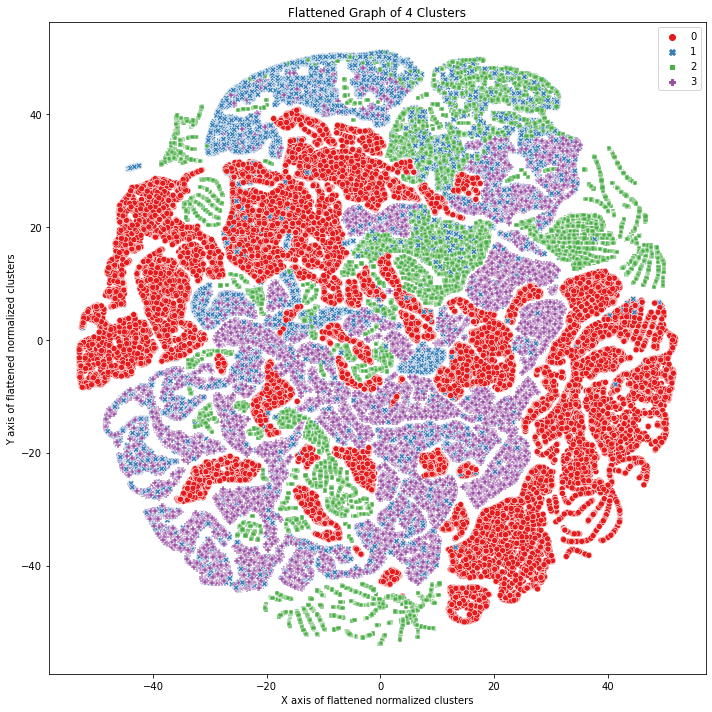

In [59]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    plt.xlabel('X axis of flattened normalized clusters')
    plt.ylabel('Y axis of flattened normalized clusters')
    return df_new


#Data set
RFM_cluster_1y = df_cluster_1y[['Frequency','Monetary','Recency']]

plt.figure(figsize=(10, 10))
df_rfm_k4_1y = kmeans(RFM_Table_scaled_1y, 4, RFM_cluster_1y)
plt.tight_layout()

#### 3D Plot - Original Data Frame

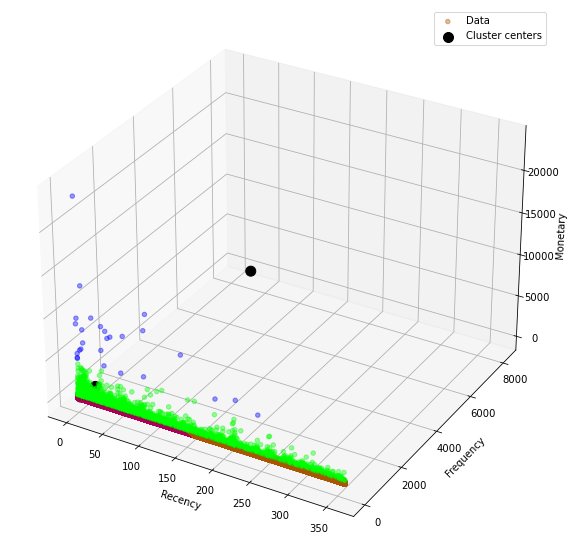

In [60]:
from mpl_toolkits.mplot3d import Axes3D

k = 4
kmeans = KMeans(n_clusters = k, random_state = 1).fit(RFM_cluster_1y)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(RFM_cluster_1y.Recency, RFM_cluster_1y.Frequency, RFM_cluster_1y.Monetary, c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c = 'black', s=100, alpha=1)
plt.legend(['Data','Cluster centers'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

Flattening three-dimensional graphs (created from Recency, Frequency, and MonetaryValue) into two-dimensional graphs for ease of visualisation. The technique for flattening high dimensional graph and visualising it in a two-dimensional format is known as **t-Distributed Stochastic Neighbor Embedding**.

#### 3D Plot - Standardized Data Frame

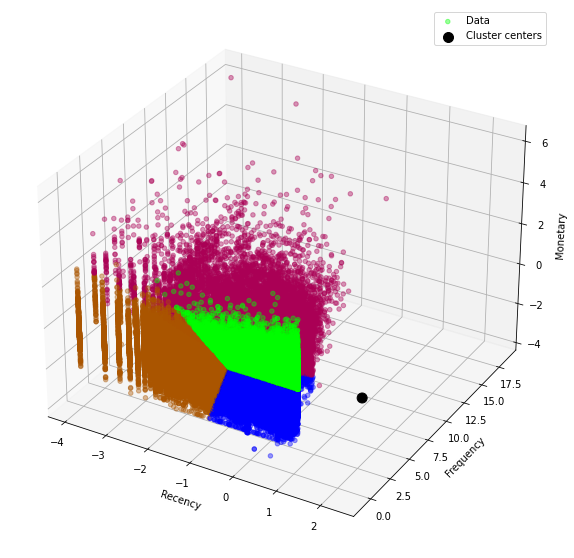

In [61]:
from mpl_toolkits.mplot3d import Axes3D

k = 4
kmeans = KMeans(n_clusters = k, random_state = 1).fit(RFM_Table_scaled_1y)

fig = plt.figure(figsize=(25, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(RFM_Table_scaled_1y.Recency, RFM_Table_scaled_1y.Frequency, RFM_Table_scaled_1y.Monetary, c=kmeans.labels_, cmap='brg', alpha=0.4)  # plot points with cluster dependent colors
ax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], kmeans.cluster_centers_[:,2], c = 'black', s=100, alpha=1)
plt.legend(['Data','Cluster centers'])
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.show()

#### Snake Plot

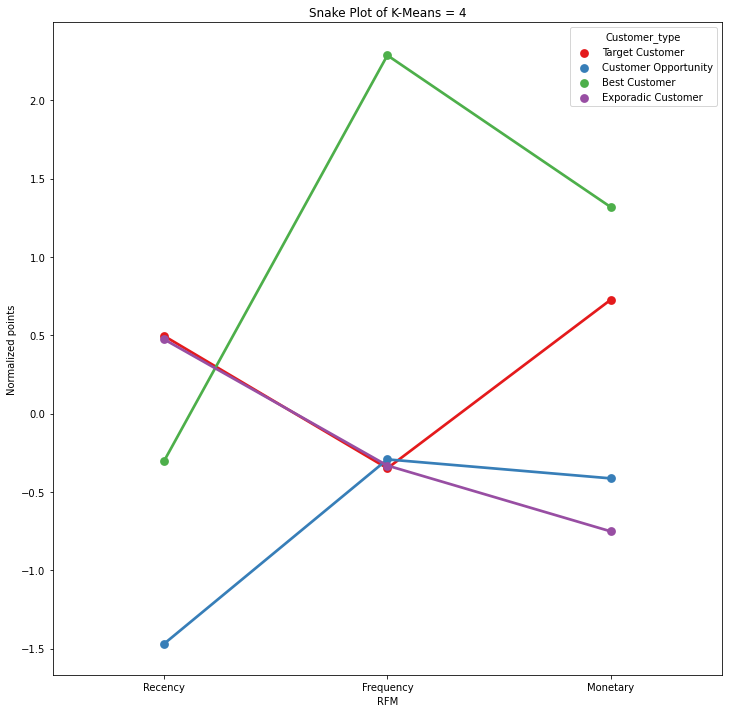

In [113]:
#df
df_rfm_k4_1y['Customer_type'] = df_rfm_k4_1y['Cluster']
df_rfm_k4_1y['Customer_type'].replace({2:'Customer Opportunity',1:'Best Customer',3:'Target Customer',0:'Exporadic Customer'}, inplace=True)



def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):

    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm_original.index, 
                                       columns=df_rfm_original.columns)
    normalised_df_rfm['Customer_type'] = df_rfm_kmeans['Customer_type']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['Customer', 'Customer_type'],
                        value_vars=['Recency', 'Frequency', 'Monetary'], 
                        var_name='RFM', 
                        value_name='Normalized points')
    plt.xlabel('RFM')
    plt.ylabel('Normalized points')
    sns.pointplot(data=df_melt, x='RFM', y='Normalized points', hue='Customer_type',errwidth=0, palette='Set1')
    
    return

plt.figure(figsize=(12, 12))
plt.title('Snake Plot of K-Means = 4')
snake_plot(RFM_Table_scaled_1y, df_rfm_k4_1y, df_cluster_1y)

#### Interpretation

- **Customer Opportunity**: Consolidade as a customer
        - High Recency, a great opportunity to consolidate as a customer.
        - Low Frequency, recently bought a product, so the frequency will be low 
        - Medium Monetary

- **Best Customer**: Cannot lose the client
        - High Recency, bought recently.
        - High Frequency, frequently buyer 
        - Hgih Monetary, spend more than the average customers

- **Target Customer**: Work hard to be a closer client
        - Low Recency, a great opportunity to consolidate as a customer.
        - Medium Frequency, recently bought a product, so the frequency will be low 
        - High Monetary

- **Exporadic Customer**: Everything from here is a bonus.
        - Low Recency, a great opportunity to consolidate as a customer.
        - Low Frequency, recently bought a product, so the frequency will be low 
        - Low Monetary

In [114]:
def rfm_values(df):

    df_new = df.groupby(['Customer_type','Cluster']).agg({
        'Recency': ['mean','median'],
        'Frequency': ['mean','median'],
        'Monetary': ['mean','median','count']
    }).round(2)
    
    return df_new

rfm_values(df_rfm_k4_1y)

Recency        Frequency        Monetary          \
                                mean median      mean median     mean  median   
Customer_type        Cluster                                                    
Best Customer        1        106.46     85      2.70      2   275.63  177.25   
Customer Opportunity 2         22.34     21      1.03      1    40.09   26.04   
Exporadic Customer   0        187.28    187      1.01      1    22.32   21.11   
Target Customer      3        194.90    207      1.00      1   111.44   94.40   

                                     
                              count  
Customer_type        Cluster         
Best Customer        1        17524  
Customer Opportunity 2        27485  
Exporadic Customer   0        54417  
Target Customer      3        40120

#### Evaluation

In [115]:
#Tranformations
df_12m = pd.merge(df_cluster_1y,df_rfm_k4_1y, right_index=True, left_index=True)
df_12m = df_12m[['Customer', 'Frequency_x', 'Monetary_x', 'Recency_x', 'Cluster']]
df_12m.rename(columns ={'Customer':'Customer','Frequency_x':'Frequency','Monetary_x':'Monetary','Recency_x':'Recency'}, inplace=True)

#df
df_12m['Customer_type'] = df_12m['Cluster']
df_12m['Customer_type'].replace({2:'Customer Opportunity',1:'Best Customer',3:'Target Customer',0:'Exporadic Customer'}, inplace=True)
df_12m

Customer  Frequency  Monetary  \
0       0000179956ad470b814e96c6c9f47b0faefcf4b0          1     64.72   
1       00029736b495db897a94099c5378a6c0ac76e288          1     39.03   
2       00031ac41eb5b21be5b4fbc1d50dd43948e01357          3    282.76   
3       00035cffce191437bd00adea61d73a346b3965d5          1     19.05   
4       0003816b0a2a45fd62432a602f73485e5e6a6c2d          1     15.39   
...                                          ...        ...       ...   
139541  fffdaf75cbff98b85a4c53a3866900ba4bf1d9dd          1     13.47   
139542  fffdb706d9f994e5732b6dd85bc4b181a5d3cda1          1      2.31   
139543  fffdb9bcceac96a27529fb2b46a6a4f9c0b7c5c6          1    227.20   
139544  fffe3332824df69941cd74912548aeb74c10c9cf          1    129.90   
139545  fffe603af1b9d46985202f19d85730fb93af827d          4    706.83   

        Recency  Cluster         Customer_type  
0           326        3       Target Customer  
1             7        2  Customer Opportunity  
2            90        1         Best Customer  
3             8        2  Customer Opportunity  
4           195        0    Exporadic Customer  
...         ...      ...                   ...  
139541       48        0    Exporadic Customer  
139542      152        0    Exporadic Customer  
139543      126        3       Target Customer  
139544       32        3       Target Customer  
139545       20        1         Best Customer  

[139546 rows x 6 columns]

-----------------------------

## 1.2 K-Means:  Filter Feature Method

###  Filter Feature Method: 6 months

In [118]:
df_features = df[['product_total_amount_trend','product_net_amount_trend','product_qty_ordered_trend',\
                  'product_total_discount_trend','num_orders_90d','free_shipping_sum','with_discount_sum',\
                  'with_discount_pct','order_shipping_price_trend','number_brands_sum','num_orders_60d',\
                  'product_net_amount_sum','product_total_amount_sum','free_shipping_pct','number_sku_sum']]
df_features.head()

product_total_amount_trend  product_net_amount_trend  \
0                         1.0                       1.0   
1                         1.0                       1.0   
2                         1.0                       1.0   
3                         1.0                       1.0   
4                         1.0                       1.0   

   product_qty_ordered_trend  product_total_discount_trend  num_orders_90d  \
0                        1.0                           1.0             1.0   
1                        1.0                           1.0             0.0   
2                        1.0                           1.0             1.0   
3                        1.0                           1.0             1.0   
4                        1.0                           1.0             1.0   

   free_shipping_sum  with_discount_sum  with_discount_pct  \
0                  0                  1                1.0   
1                  1                  0                0.0   
2                  0                  0                0.0   
3                  0                  0                0.0   
4                  0                  0                0.0   

   order_shipping_price_trend  number_brands_sum  num_orders_60d  \
0                         1.0                  3             1.0   
1                         1.0                  3             0.0   
2                         1.0                  1             1.0   
3                         1.0                  1             0.0   
4                         1.0                  1             1.0   

   product_net_amount_sum  product_total_amount_sum  free_shipping_pct  \
0                   39.03                     52.88                0.0   
1                  107.77                    107.77                1.0   
2                   19.05                     19.05                0.0   
3                   14.46                     14.46                0.0   
4                   17.45                     17.45                0.0   

   number_sku_sum  
0               3  
1               4  
2               1  
3               1  
4               1

#### Skewness

product_total_amount_trend's: Skew: 1.8700708715496863, : SkewtestResult(statistic=151.8244402702935, pvalue=0.0)
product_net_amount_trend's: Skew: 1.333666898396474, : SkewtestResult(statistic=122.75805800579424, pvalue=0.0)
product_qty_ordered_trend's: Skew: 2.495368581045276, : SkewtestResult(statistic=177.96053848876033, pvalue=0.0)
product_total_discount_trend's: Skew: 4.708279571412244, : SkewtestResult(statistic=237.72518631748025, pvalue=0.0)
num_orders_90d's: Skew: 6.602124823687036, : SkewtestResult(statistic=270.14248139040876, pvalue=0.0)
free_shipping_sum's: Skew: 22.69985207825557, : SkewtestResult(statistic=389.5124362733075, pvalue=0.0)
with_discount_sum's: Skew: 13.796327266099441, : SkewtestResult(statistic=341.2982399940891, pvalue=0.0)
with_discount_pct's: Skew: 0.4570210159752341, : SkewtestResult(statistic=51.754373559792846, pvalue=0.0)
order_shipping_price_trend's: Skew: 5.906986338088991, : SkewtestResult(statistic=259.44950466352947, pvalue=0.0)
number_brands_

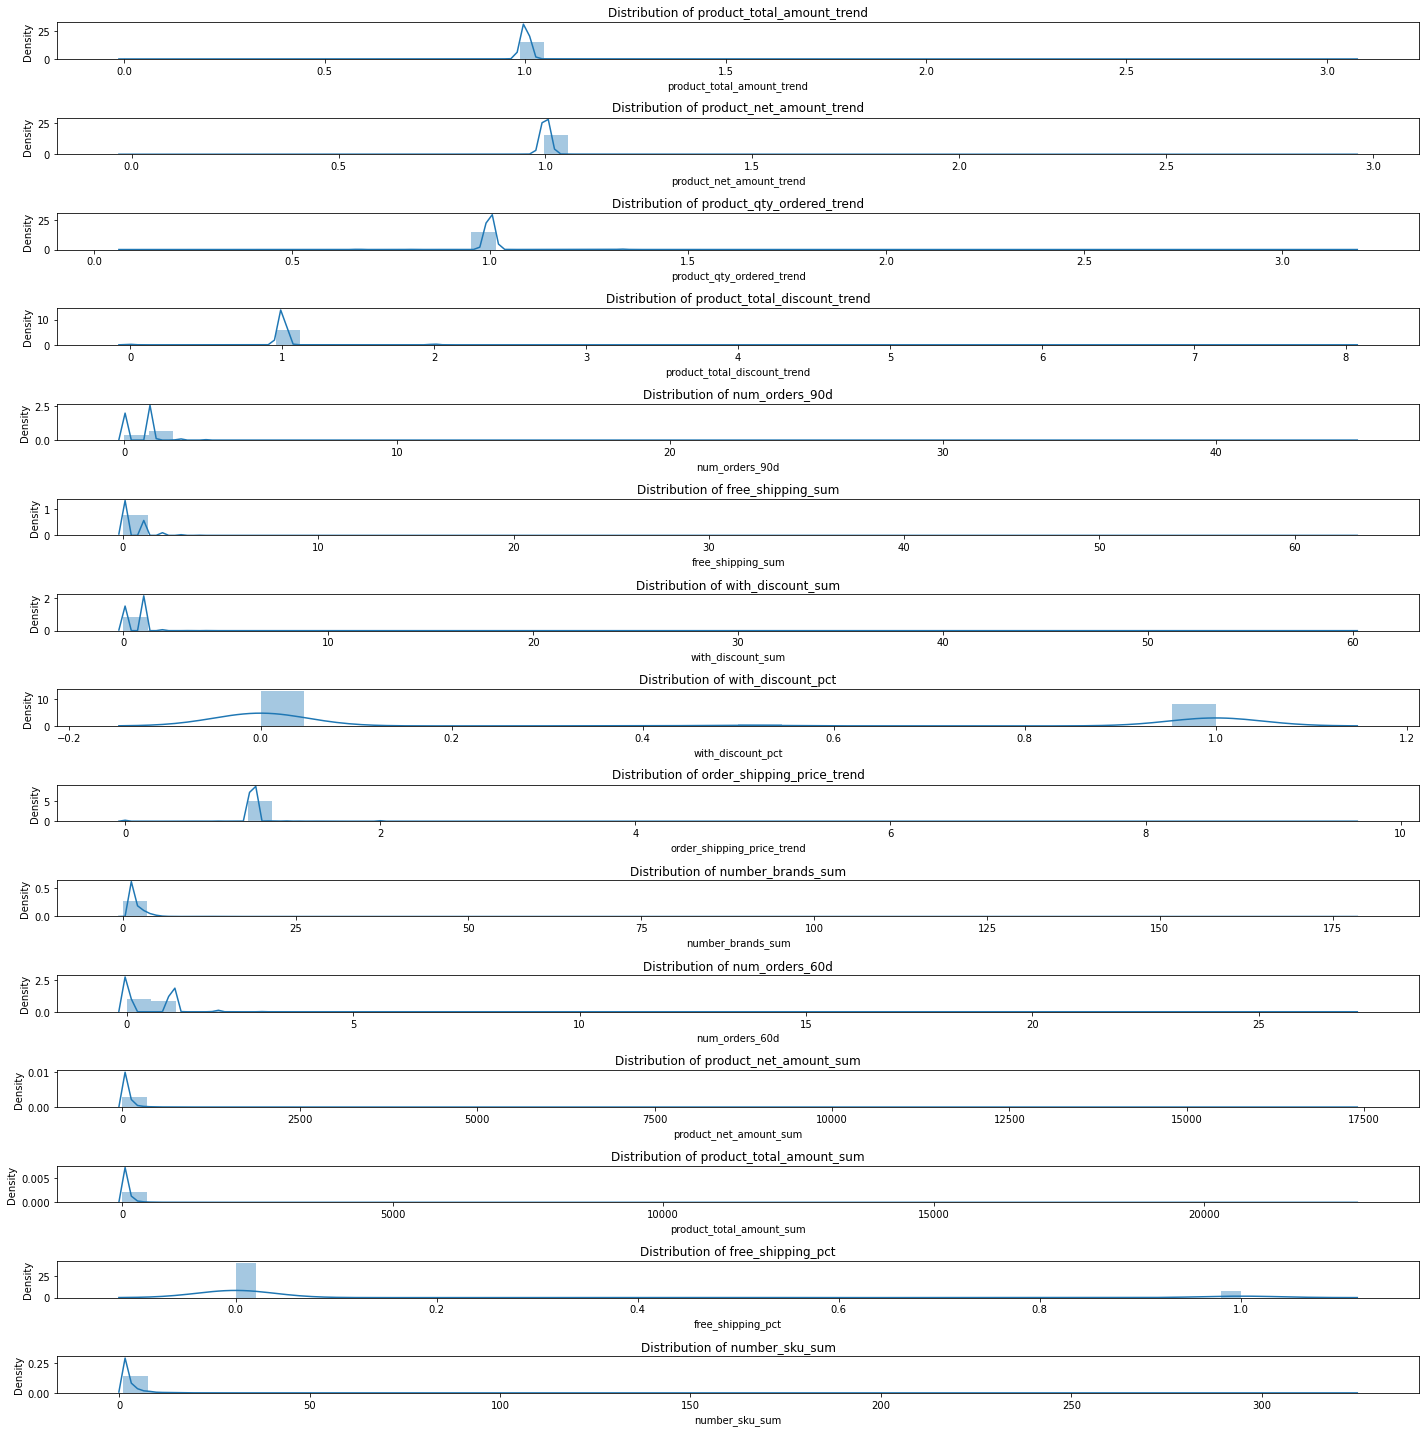

In [148]:
plt.figure (figsize=(20,20))

#product_total_amount_trend
plt.subplot(15,1,1)
check_skew(df_features, 'product_total_amount_trend')

#product_net_amount_trend
plt.subplot(15,1,2)
check_skew(df_features, 'product_net_amount_trend')

#product_qty_ordered_trend
plt.subplot(15,1,3)
check_skew(df_features, 'product_qty_ordered_trend')

#product_total_discount_trend
plt.subplot(15,1,4)
check_skew(df_features, 'product_total_discount_trend')

#num_orders_90d
plt.subplot(15,1,5)
check_skew(df_features, 'num_orders_90d')

#free_shipping_sum
plt.subplot(15,1,6)
check_skew(df_features, 'free_shipping_sum')

#with_discount_sum
plt.subplot(15,1,7)
check_skew(df_features, 'with_discount_sum')

#with_discount_pct
plt.subplot(15,1,8)
check_skew(df_features, 'with_discount_pct')

#order_shipping_price_trend
plt.subplot(15,1,9)
check_skew(df_features, 'order_shipping_price_trend')

#number_brands_sum
plt.subplot(15,1,10)
check_skew(df_features, 'number_brands_sum')

#num_orders_60d
plt.subplot(15,1,11)
check_skew(df_features, 'num_orders_60d')

#product_net_amount_sum
plt.subplot(15,1,12)
check_skew(df_features, 'product_net_amount_sum')

#product_total_amount_sum
plt.subplot(15,1,13)
check_skew(df_features, 'product_total_amount_sum')

#free_shipping_pct
plt.subplot(15,1,14)
check_skew(df_features, 'free_shipping_pct')

#number_sku_sum
plt.subplot(15,1,15)
check_skew(df_features, 'number_sku_sum')

plt.tight_layout()

The data is **highly skewed**, therefore we will perform **log transformations** to reduce the skewness of each variable. 

product_total_amount_trend's: Skew: -0.985900337887086, : SkewtestResult(statistic=-98.93298861412073, pvalue=0.0)
product_net_amount_trend's: Skew: -1.5633188068078259, : SkewtestResult(statistic=-136.15883407970975, pvalue=0.0)
product_qty_ordered_trend's: Skew: -0.16348409750175605, : SkewtestResult(statistic=-19.278314971191175, pvalue=8.169466434743394e-83)
product_total_discount_trend's: Skew: -0.7446830248533659, : SkewtestResult(statistic=-79.26137494744584, pvalue=0.0)
num_orders_90d's: Skew: -0.18706341919215103, : SkewtestResult(statistic=-22.01479026413967, pvalue=2.0783017516627777e-107)
free_shipping_sum's: Skew: 2.2296349255037025, : SkewtestResult(statistic=167.64775478470247, pvalue=0.0)
with_discount_sum's: Skew: 0.714532619096711, : SkewtestResult(statistic=76.59253755881504, pvalue=0.0)
with_discount_pct's: Skew: 0.43733773434595763, : SkewtestResult(statistic=49.705112607516206, pvalue=0.0)
order_shipping_price_trend's: Skew: -3.8426394035941027, : SkewtestResult(s

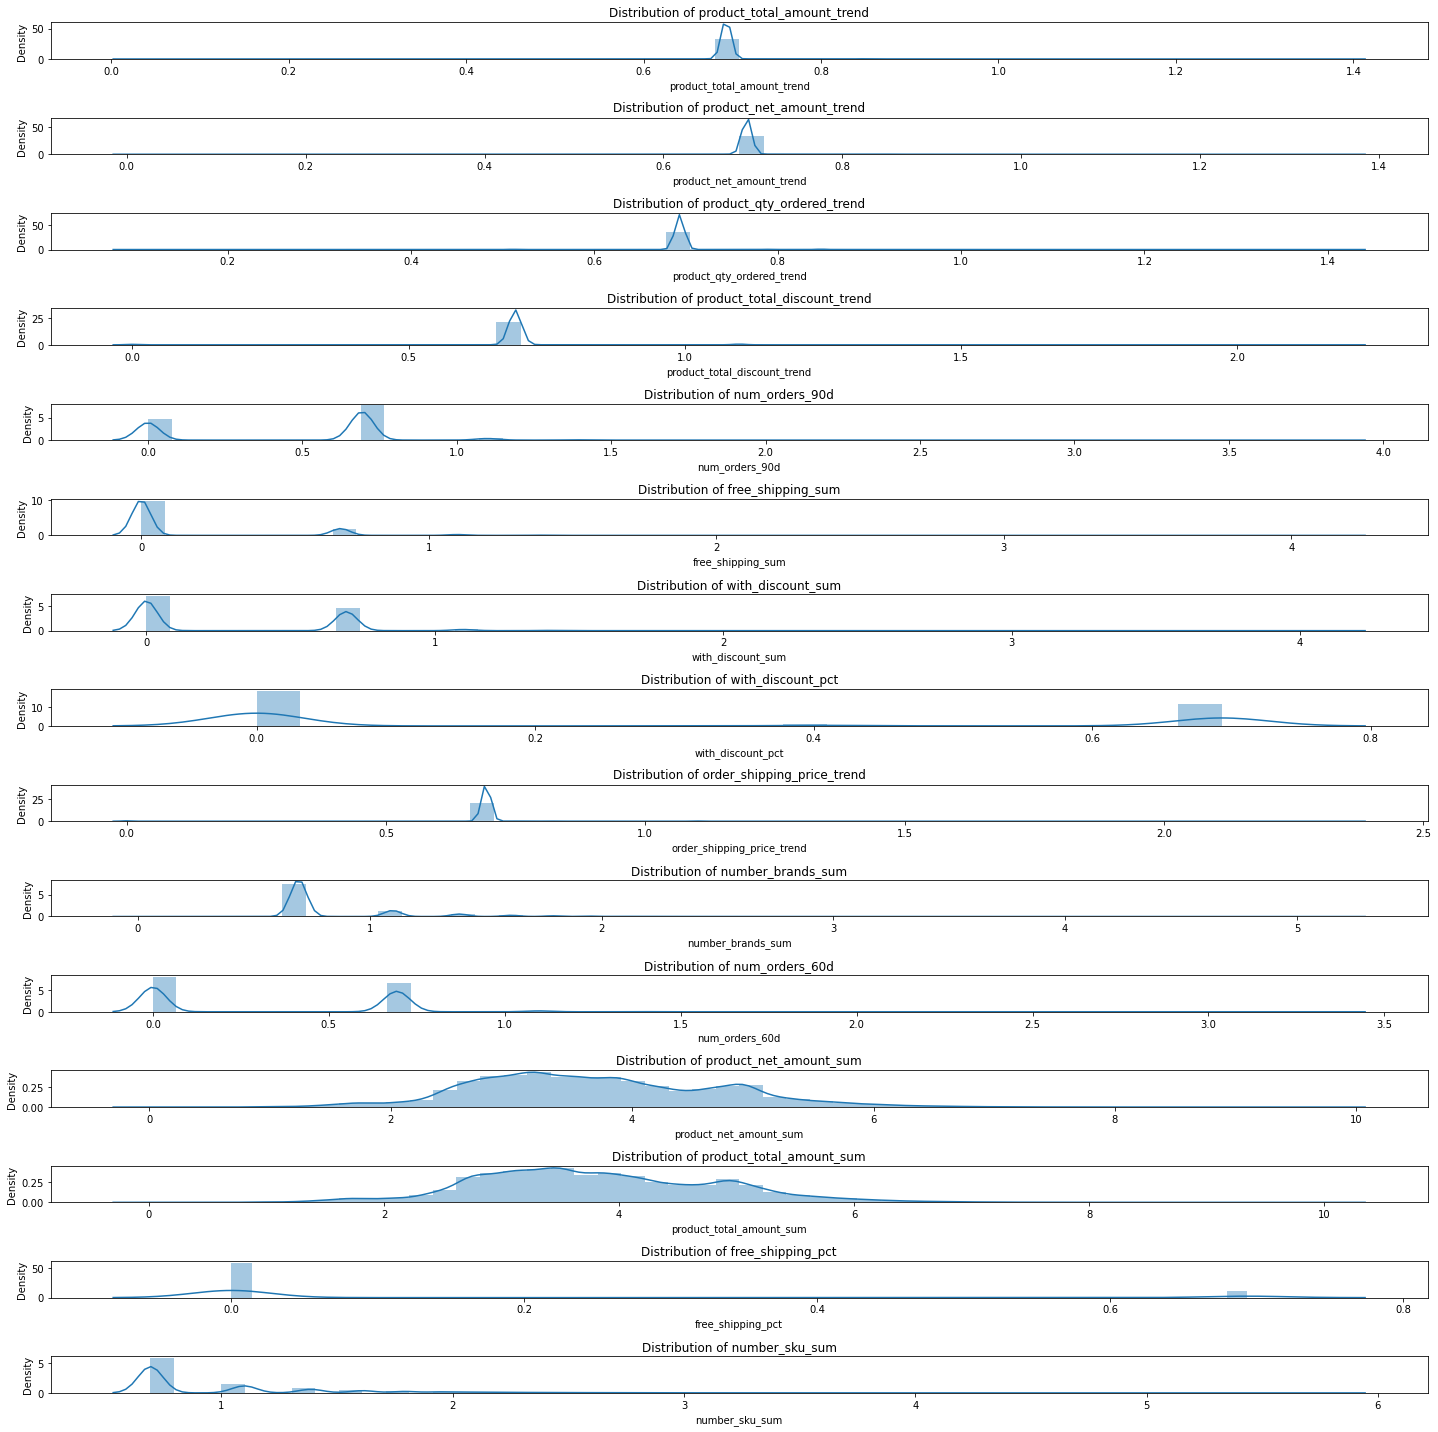

In [149]:
#Removing Skewness
df_features_log = np.log(df_features[['product_total_amount_trend','product_net_amount_trend','product_qty_ordered_trend',\
                  'product_total_discount_trend','num_orders_90d','free_shipping_sum','with_discount_sum',\
                  'with_discount_pct','order_shipping_price_trend','number_brands_sum','num_orders_60d',\
                  'product_net_amount_sum','product_total_amount_sum','free_shipping_pct','number_sku_sum']]+1)

plt.figure (figsize=(20,20))

#product_total_amount_trend
plt.subplot(15,1,1)
check_skew(df_features_log, 'product_total_amount_trend')

#product_net_amount_trend
plt.subplot(15,1,2)
check_skew(df_features_log, 'product_net_amount_trend')

#product_qty_ordered_trend
plt.subplot(15,1,3)
check_skew(df_features_log, 'product_qty_ordered_trend')

#product_total_discount_trend
plt.subplot(15,1,4)
check_skew(df_features_log, 'product_total_discount_trend')

#num_orders_90d
plt.subplot(15,1,5)
check_skew(df_features_log, 'num_orders_90d')

#free_shipping_sum
plt.subplot(15,1,6)
check_skew(df_features_log, 'free_shipping_sum')

#with_discount_sum
plt.subplot(15,1,7)
check_skew(df_features_log, 'with_discount_sum')

#with_discount_pct
plt.subplot(15,1,8)
check_skew(df_features_log, 'with_discount_pct')

#order_shipping_price_trend
plt.subplot(15,1,9)
check_skew(df_features_log, 'order_shipping_price_trend')

#number_brands_sum
plt.subplot(15,1,10)
check_skew(df_features_log, 'number_brands_sum')

#num_orders_60d
plt.subplot(15,1,11)
check_skew(df_features_log, 'num_orders_60d')

#product_net_amount_sum
plt.subplot(15,1,12)
check_skew(df_features_log, 'product_net_amount_sum')

#product_total_amount_sum
plt.subplot(15,1,13)
check_skew(df_features_log, 'product_total_amount_sum')

#free_shipping_pct
plt.subplot(15,1,14)
check_skew(df_features_log, 'free_shipping_pct')

#number_sku_sum
plt.subplot(15,1,15)
check_skew(df_features_log, 'number_sku_sum')

plt.tight_layout()

**Scaling** is important to **uniform** the data with same distance scale, `K-Means` might not form meaningful cluster, because the algorithm is based on the `euclidean-distance` between data points.

In [122]:
scaler = StandardScaler()
scaler.fit(df_features_log)
RFM_Features_scaled = scaler.transform(df_features_log)

#dataframe
RFM_Features_scaled = pd.DataFrame(RFM_Features_scaled, columns=df_features_log.columns)
RFM_Features_scaled.head()

product_total_amount_trend  product_net_amount_trend  \
0                   -0.022968                 -0.003632   
1                   -0.022968                 -0.003632   
2                   -0.022968                 -0.003632   
3                   -0.022968                 -0.003632   
4                   -0.022968                 -0.003632   

   product_qty_ordered_trend  product_total_discount_trend  num_orders_90d  \
0                  -0.037382                     -0.026981        0.646358   
1                  -0.037382                     -0.026981       -1.266642   
2                  -0.037382                     -0.026981        0.646358   
3                  -0.037382                     -0.026981        0.646358   
4                  -0.037382                     -0.026981        0.646358   

   free_shipping_sum  with_discount_sum  with_discount_pct  \
0          -0.451510           1.066208           1.270162   
1           1.751814          -0.802845          -0.818125   
2          -0.451510          -0.802845          -0.818125   
3          -0.451510          -0.802845          -0.818125   
4          -0.451510          -0.802845          -0.818125   

   order_shipping_price_trend  number_brands_sum  num_orders_60d  \
0                    0.038557           1.545588        0.987322   
1                    0.038557           1.545588       -0.916450   
2                    0.038557          -0.465578        0.987322   
3                    0.038557          -0.465578       -0.916450   
4                    0.038557          -0.465578        0.987322   

   product_net_amount_sum  product_total_amount_sum  free_shipping_pct  \
0               -0.021803                  0.171395          -0.469017   
1                0.977119                  0.867180           2.194665   
2               -0.712730                 -0.807720          -0.469017   
3               -0.972525                 -1.065216          -0.469017   
4               -0.795837                 -0.890092          -0.469017   

   number_sku_sum  
0        0.676080  
1        1.105316  
2       -0.657252  
3       -0.657252  
4       -0.657252

#### Define K

In [123]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(RFM_Features_scaled) 
    kmeanModel.fit(RFM_Features_scaled)     
      
    distortions.append(sum(np.min(cdist(RFM_Features_scaled, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / RFM_Features_scaled.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(RFM_Features_scaled, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / RFM_Features_scaled.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

`Inertia` is the sum of squared distances of samples to their closest cluster centre.

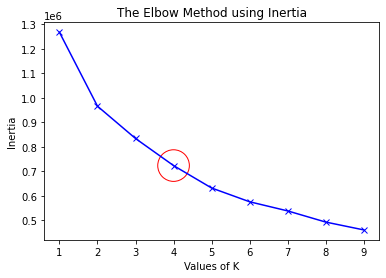

In [126]:
plt.plot(K, inertias, 'bx-')
plt.scatter( 4 , 723125.1798830997 , s=1000 ,  facecolors='none', edgecolors='red' ) 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [125]:
#The optimal number of cluster can be any number between 4 upto 7.
SSED = mapping2
SSED

{1: 1267859.9999999981,
 2: 965854.561294646,
 3: 833798.6449522681,
 4: 723125.1798830997,
 5: 631511.0949607932,
 6: 575211.7768925612,
 7: 537902.17639614,
 8: 492301.668886752,
 9: 460271.62996222643}

### Visualize Clusters

#### 2D Plot

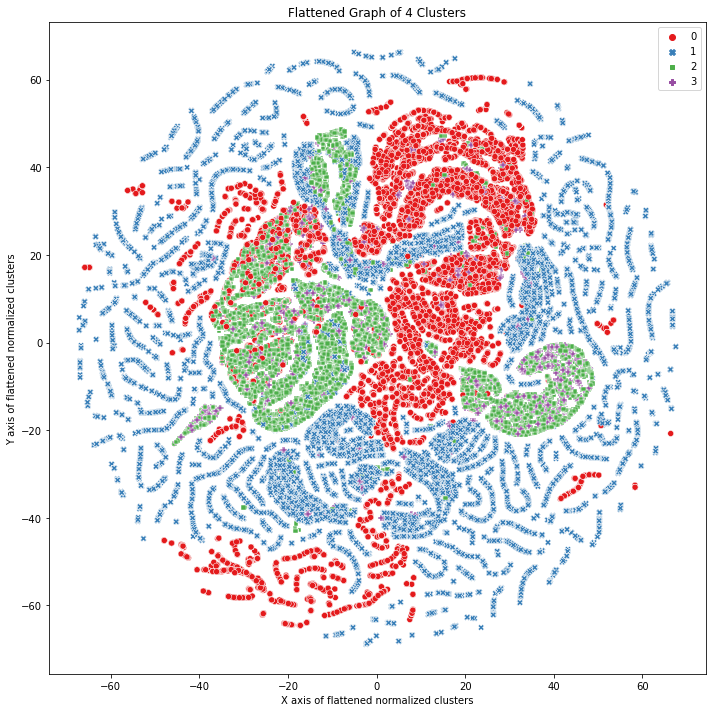

In [127]:
def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    plt.xlabel('X axis of flattened normalized clusters')
    plt.ylabel('Y axis of flattened normalized clusters')
    return df_new

df_wrapper_features = df[['product_total_amount_trend','product_net_amount_trend','product_qty_ordered_trend',\
                  'product_total_discount_trend','num_orders_90d','free_shipping_sum','with_discount_sum',\
                  'with_discount_pct','order_shipping_price_trend','number_brands_sum','num_orders_60d',\
                  'product_net_amount_sum','product_total_amount_sum','free_shipping_pct','number_sku_sum']]

plt.figure(figsize=(10, 10))
df_wrapper_k4 = kmeans(RFM_Features_scaled, 4, df_wrapper_features)
plt.tight_layout()

#### Snake Plot

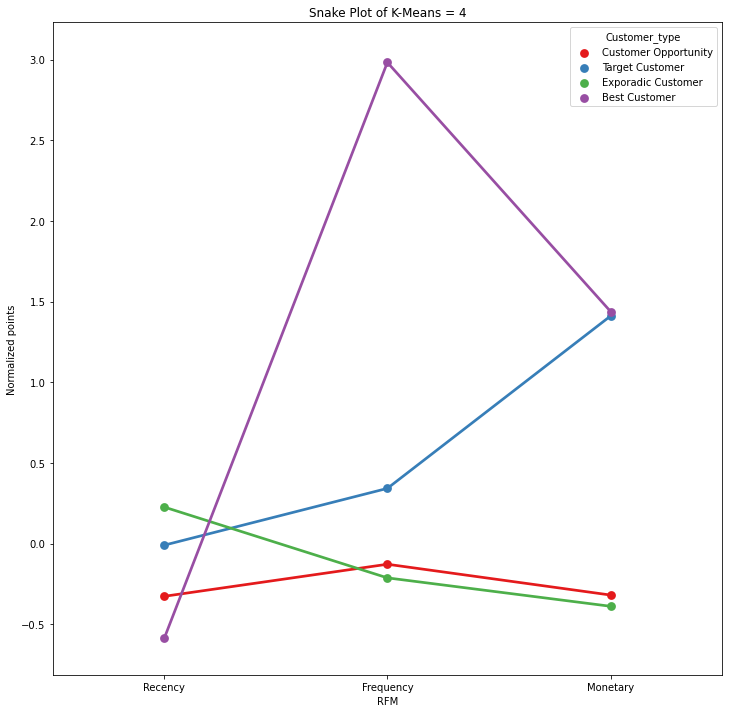

In [203]:
#Create Dataset to Analyse the data
df_analysis=pd.merge(df,df_wrapper_k4, right_index=True, left_index=True)
df_analysis = df_analysis[['CustomerUniqueIdEmailHash', 'num_orders','product_net_amount_sum_y','days_since_last_buy','Cluster']]
df_analysis.rename(columns ={'num_orders':'Frequency','product_net_amount_sum_y':'Monetary','days_since_last_buy':'Recency'}, inplace=True)

#Df features
df_features_ana = df_analysis[['CustomerUniqueIdEmailHash','Frequency','Monetary','Recency']]

#df_cluster
df_cluster = df_analysis[['Frequency','Monetary','Recency','Cluster']]

#Scaled dataset
normalize2= df_analysis[['Frequency','Monetary','Recency']]
#Removing skewness
df_hie_log_ana = np.log(normalize2+1)
# Normalizing
scaler = StandardScaler()
scaler.fit(df_hie_log_ana)
Hie_scaled_ana = scaler.transform(df_hie_log_ana)
#Dataframe
Hie_scaled_ana = pd.DataFrame(Hie_scaled_ana, columns=normalize2.columns)

#df
df_cluster['Customer_type'] = df_cluster['Cluster']
df_cluster['Customer_type'].replace({0:'Customer Opportunity',3:'Best Customer',2:'Target Customer',1:'Exporadic Customer'}, inplace=True)

def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm_original.index, 
                                       columns=df_rfm_original.columns)
    normalised_df_rfm['Customer_type'] = df_rfm_kmeans['Customer_type']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerUniqueIdEmailHash', 'Customer_type'],
                        value_vars=['Recency','Frequency','Monetary'], 
                        var_name='RFM', 
                        value_name='Normalized points')

    plt.xlabel('RFM')
    plt.ylabel('Normalized points')
    sns.pointplot(data=df_melt, x='RFM', y='Normalized points', hue='Customer_type', errwidth=0, palette='Set1') 
    return

plt.figure(figsize=(12, 12))
plt.title('Snake Plot of K-Means = 4')
snake_plot(Hie_scaled_ana, df_cluster, df_features_ana)

#### Interpretation

- **Customer Opportunity**: Consolidade as a customer
        - High Recency, a great opportunity to consolidate as a customer.
        - Low Frequency, recently bought a product, so the frequency will be low 
        - Medium Monetary

- **Best Customer**: Cannot lose the client
        - High Recency, bought recently.
        - High Frequency, frequently buyer 
        - Hgih Monetary, spend more than the average customers

- **Target Customer**: Work hard to be a closer client
        - Medium Recency, a great opportunity to consolidate as a customer.
        - Medium Frequency, recently bought a product, so the frequency will be low 
        - Medium Monetary

- **Exporadic Customer**: Everything from here is a bonus.
        - Low Recency, a great opportunity to consolidate as a customer.
        - Low Frequency, recently bought a product, so the frequency will be low 
        - Low Monetary

In [137]:
def rfm_values(df):

    df_new = df.groupby(['Customer_type','Cluster']).agg({
        'Recency': ['mean','median'],
        'Frequency': ['mean','median'],
        'Monetary': ['mean','median','count']
    }).round(2)
    
    return df_new

rfm_values(df_cluster)

Recency        Frequency        Monetary          \
                                mean median      mean median     mean  median   
Customer_type        Cluster                                                    
Best Customer        3         42.77     32      2.55      2   260.45  169.19   
Customer Opportunity 0         55.19     40      1.07      1    36.44   26.98   
Exporadic Customer   1         83.67     79      1.03      1    35.31   27.14   
Target Customer      2         72.43     66      1.32      1   201.55  145.09   

                                     
                              count  
Customer_type        Cluster         
Best Customer        3         2356  
Customer Opportunity 0        24951  
Exporadic Customer   1        42371  
Target Customer      2        14846

#### Evaluation

In [144]:
# Data Frame
df_fea_6m = df_cluster
df_fea_6m = pd.merge(df,df_cluster, right_index=True, left_index=True)
df_fea_6m = df_fea_6m[['CustomerUniqueIdEmailHash','Frequency', 'Monetary', 'Recency', 'Cluster','Customer_type']]
df_fea_6m

CustomerUniqueIdEmailHash  Frequency  Monetary  Recency  \
0      00029736b495db897a94099c5378a6c0ac76e288          1     39.03        7   
1      00031ac41eb5b21be5b4fbc1d50dd43948e01357          1    107.77       90   
2      00035cffce191437bd00adea61d73a346b3965d5          1     19.05        8   
3      0003dfdcbabb0a33168e9b5b09b1f08fb0a960f9          1     14.46       84   
4      00056521f6daa362ea4b49a3dfaff7e6433edb60          1     17.45       38   
...                                         ...        ...       ...      ...   
84519  fffdaf75cbff98b85a4c53a3866900ba4bf1d9dd          1     13.47       48   
84520  fffdb706d9f994e5732b6dd85bc4b181a5d3cda1          1      2.31      152   
84521  fffdb9bcceac96a27529fb2b46a6a4f9c0b7c5c6          1    227.20      126   
84522  fffe3332824df69941cd74912548aeb74c10c9cf          1    129.90       32   
84523  fffe603af1b9d46985202f19d85730fb93af827d          2    405.75       20   

       Cluster         Customer_type  
0            0  Customer Opportunity  
1            2       Target Customer  
2            1    Exporadic Customer  
3            1    Exporadic Customer  
4            1    Exporadic Customer  
...        ...                   ...  
84519        1    Exporadic Customer  
84520        1    Exporadic Customer  
84521        2       Target Customer  
84522        2       Target Customer  
84523        2       Target Customer  

[84524 rows x 6 columns]

#### 3D Plot - Standart Dataset

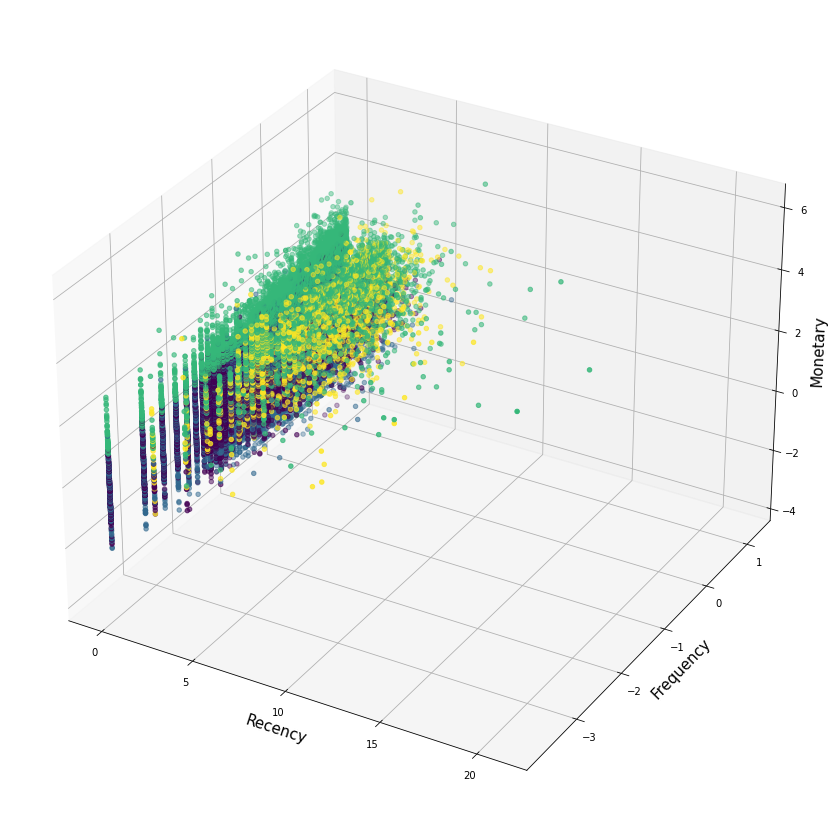

In [195]:
#log
df_fea_6m_log = np.log(df_fea_6m[['Frequency','Monetary','Recency']]+1)

#Standard
scaler = StandardScaler()
scaler.fit(df_fea_6m_log)
df_fea_6m_scaled = scaler.transform(df_fea_6m_log)

#dataframe
df_fea_6m_scaled = pd.DataFrame(df_fea_6m_scaled, columns=df_fea_6m_log.columns)

#merge
merge = df_fea_6m[['CustomerUniqueIdEmailHash','Cluster','Customer_type']]
df_fea_6m_scaled = pd.merge(merge,df_fea_6m_scaled,left_index=True, right_index=True)

#size
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata =  df_fea_6m_scaled['Monetary']
xdata = df_fea_6m_scaled['Frequency']
ydata = df_fea_6m_scaled['Recency']


ax.scatter3D(xdata, ydata, zdata, c=df_fea_6m_scaled['Cluster'] )



ax.set_xlabel('Recency',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.set_zlabel('Monetary',fontsize=15)

plt.show()

--------------------------

##  Filter Feature Method: 1 year

In [174]:
df_features_1y = df_1y[['product_total_amount_trend','product_net_amount_trend','product_qty_ordered_trend',\
                  'product_total_discount_trend','num_orders_90d','free_shipping_sum','with_discount_sum',\
                  'with_discount_pct','order_shipping_price_trend','number_brands_sum','num_orders_60d',\
                  'product_net_amount_sum','product_total_amount_sum','free_shipping_pct','number_sku_sum']]
df_features_1y

product_total_amount_trend  product_net_amount_trend  \
0                         1.000000                  1.000000   
1                         1.000000                  1.000000   
2                         1.143408                  1.143408   
3                         1.000000                  1.000000   
4                         1.000000                  1.000000   
...                            ...                       ...   
139541                    1.000000                  1.000000   
139542                    1.000000                  1.000000   
139543                    1.000000                  1.000000   
139544                    1.000000                  1.000000   
139545                    0.983490                  0.983490   

        product_qty_ordered_trend  product_total_discount_trend  \
0                        1.000000                           1.0   
1                        1.000000                           1.0   
2                        1.333333                           1.0   
3                        1.000000                           1.0   
4                        1.000000                           1.0   
...                           ...                           ...   
139541                   1.000000                           1.0   
139542                   1.000000                           1.0   
139543                   1.000000                           1.0   
139544                   1.000000                           1.0   
139545                   0.941176                           1.0   

        num_orders_90d  free_shipping_sum  with_discount_sum  \
0                  0.0                  0                  0   
1                  1.0                  0                  1   
2                  0.0                  2                  0   
3                  1.0                  0                  0   
4                  0.0                  0                  1   
...                ...                ...                ...   
139541             1.0                  0                  0   
139542             0.0                  0                  0   
139543             0.0                  1                  1   
139544             1.0                  1                  1   
139545             2.0                  3                  0   

        with_discount_pct  order_shipping_price_trend  number_brands_sum  \
0                     0.0                         1.0                  1   
1                     1.0                         1.0                  3   
2                     0.0                         0.0                  6   
3                     0.0                         1.0                  1   
4                     1.0                         1.0                  1   
...                   ...                         ...                ...   
139541                0.0                         1.0                  1   
139542                0.0                         1.0                  1   
139543                1.0                         1.0                  4   
139544                1.0                         1.0                  2   
139545                0.0                         0.0                  4   

        num_orders_60d  product_net_amount_sum  product_total_amount_sum  \
0                  0.0                   64.72                     64.72   
1                  1.0                   39.03                     52.88   
2                  0.0                  282.76                    282.76   
3                  1.0                   19.05                     19.05   
4                  0.0                   15.39                     20.52   
...                ...                     ...                       ...   
139541             1.0                   13.47                     13.47   
139542             0.0                    2.31                      2.31   
139543             0.0                  227.20                    23

#### skewness

product_total_amount_trend's: Skew: 1.7038511237173493, : SkewtestResult(statistic=184.52698950980525, pvalue=0.0)
product_net_amount_trend's: Skew: 1.4748721488000716, : SkewtestResult(statistic=168.55310007350892, pvalue=0.0)
product_qty_ordered_trend's: Skew: 2.0509258452541204, : SkewtestResult(statistic=205.67813204827348, pvalue=0.0)
product_total_discount_trend's: Skew: 3.1365752616139004, : SkewtestResult(statistic=255.9791843240324, pvalue=0.0)
num_orders_90d's: Skew: 5.620342529207169, : SkewtestResult(statistic=327.20997400648963, pvalue=0.0)
free_shipping_sum's: Skew: 32.456768277022476, : SkewtestResult(statistic=544.9539881005785, pvalue=0.0)
with_discount_sum's: Skew: 23.899341075321978, : SkewtestResult(statistic=506.85528589746144, pvalue=0.0)
with_discount_pct's: Skew: 0.27169337437124375, : SkewtestResult(statistic=40.707919123288946, pvalue=0.0)
order_shipping_price_trend's: Skew: 5.937539832691726, : SkewtestResult(statistic=333.97996410008165, pvalue=0.0)
number_b

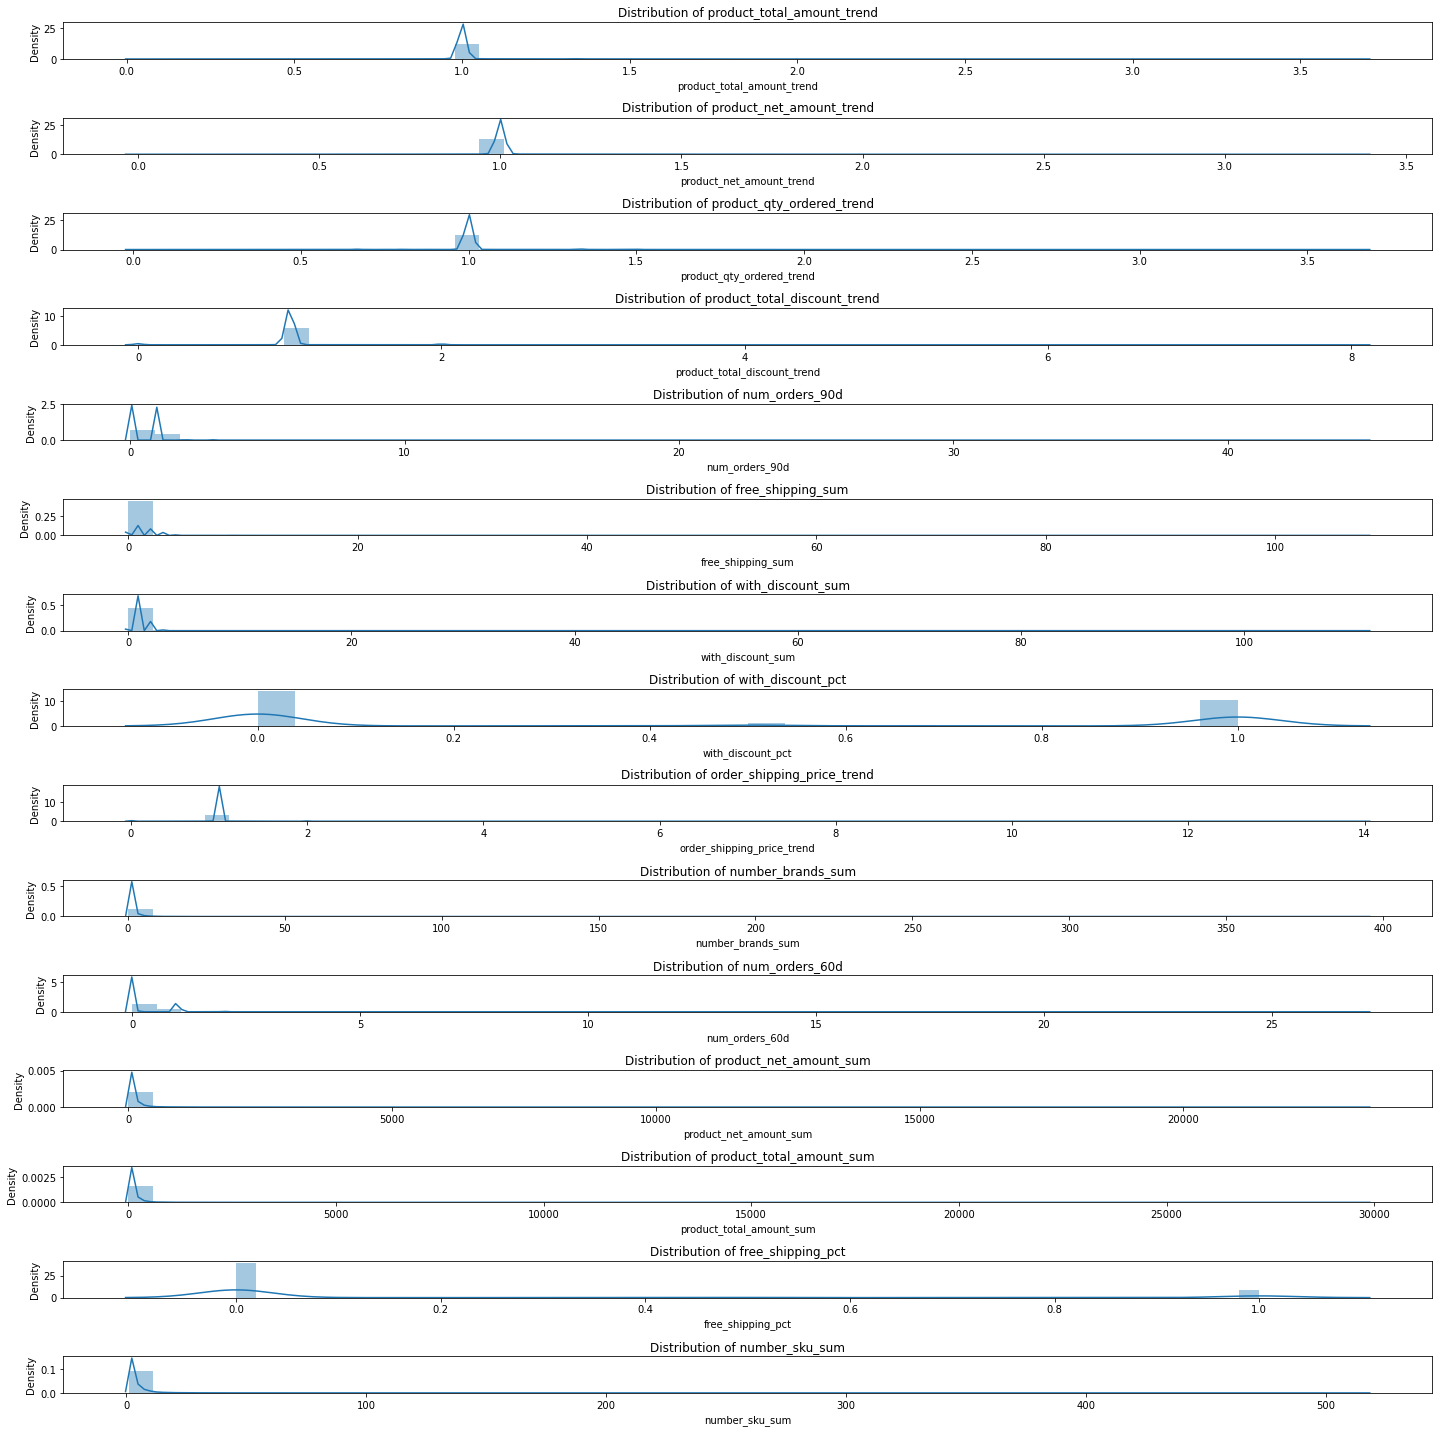

In [175]:
plt.figure (figsize=(20,20))

#product_total_amount_trend
plt.subplot(15,1,1)
check_skew(df_features_1y, 'product_total_amount_trend')

#product_net_amount_trend
plt.subplot(15,1,2)
check_skew(df_features_1y, 'product_net_amount_trend')

#product_qty_ordered_trend
plt.subplot(15,1,3)
check_skew(df_features_1y, 'product_qty_ordered_trend')

#product_total_discount_trend
plt.subplot(15,1,4)
check_skew(df_features_1y, 'product_total_discount_trend')

#num_orders_90d
plt.subplot(15,1,5)
check_skew(df_features_1y, 'num_orders_90d')

#free_shipping_sum
plt.subplot(15,1,6)
check_skew(df_features_1y, 'free_shipping_sum')

#with_discount_sum
plt.subplot(15,1,7)
check_skew(df_features_1y, 'with_discount_sum')

#with_discount_pct
plt.subplot(15,1,8)
check_skew(df_features_1y, 'with_discount_pct')

#order_shipping_price_trend
plt.subplot(15,1,9)
check_skew(df_features_1y, 'order_shipping_price_trend')

#number_brands_sum
plt.subplot(15,1,10)
check_skew(df_features_1y, 'number_brands_sum')

#num_orders_60d
plt.subplot(15,1,11)
check_skew(df_features_1y, 'num_orders_60d')

#product_net_amount_sum
plt.subplot(15,1,12)
check_skew(df_features_1y, 'product_net_amount_sum')

#product_total_amount_sum
plt.subplot(15,1,13)
check_skew(df_features_1y, 'product_total_amount_sum')

#free_shipping_pct
plt.subplot(15,1,14)
check_skew(df_features_1y, 'free_shipping_pct')

#number_sku_sum
plt.subplot(15,1,15)
check_skew(df_features_1y, 'number_sku_sum')

plt.tight_layout()

The data is **highly skewed**, therefore we will perform **log transformations** to reduce the skewness of each variable. 

product_total_amount_trend's: Skew: -0.7859476942905228, : SkewtestResult(statistic=-106.43024829658178, pvalue=0.0)
product_net_amount_trend's: Skew: -0.9812368915817168, : SkewtestResult(statistic=-126.6584125020226, pvalue=0.0)
product_qty_ordered_trend's: Skew: -0.2349031809663641, : SkewtestResult(statistic=-35.349162399449945, pvalue=1.0327493119468116e-273)
product_total_discount_trend's: Skew: -1.5248187483145048, : SkewtestResult(statistic=-172.19564714895444, pvalue=0.0)
num_orders_90d's: Skew: 0.7033120303630346, : SkewtestResult(statistic=97.11706876081551, pvalue=0.0)
free_shipping_sum's: Skew: 2.2314633034779776, : SkewtestResult(statistic=215.49343719026032, pvalue=0.0)
with_discount_sum's: Skew: 0.6840464604048863, : SkewtestResult(statistic=94.87775564719226, pvalue=0.0)
with_discount_pct's: Skew: 0.24236061200617, : SkewtestResult(statistic=36.440851270820644, pvalue=9.604271702377914e-291)
order_shipping_price_trend's: Skew: -2.932701359291804, : SkewtestResult(stati

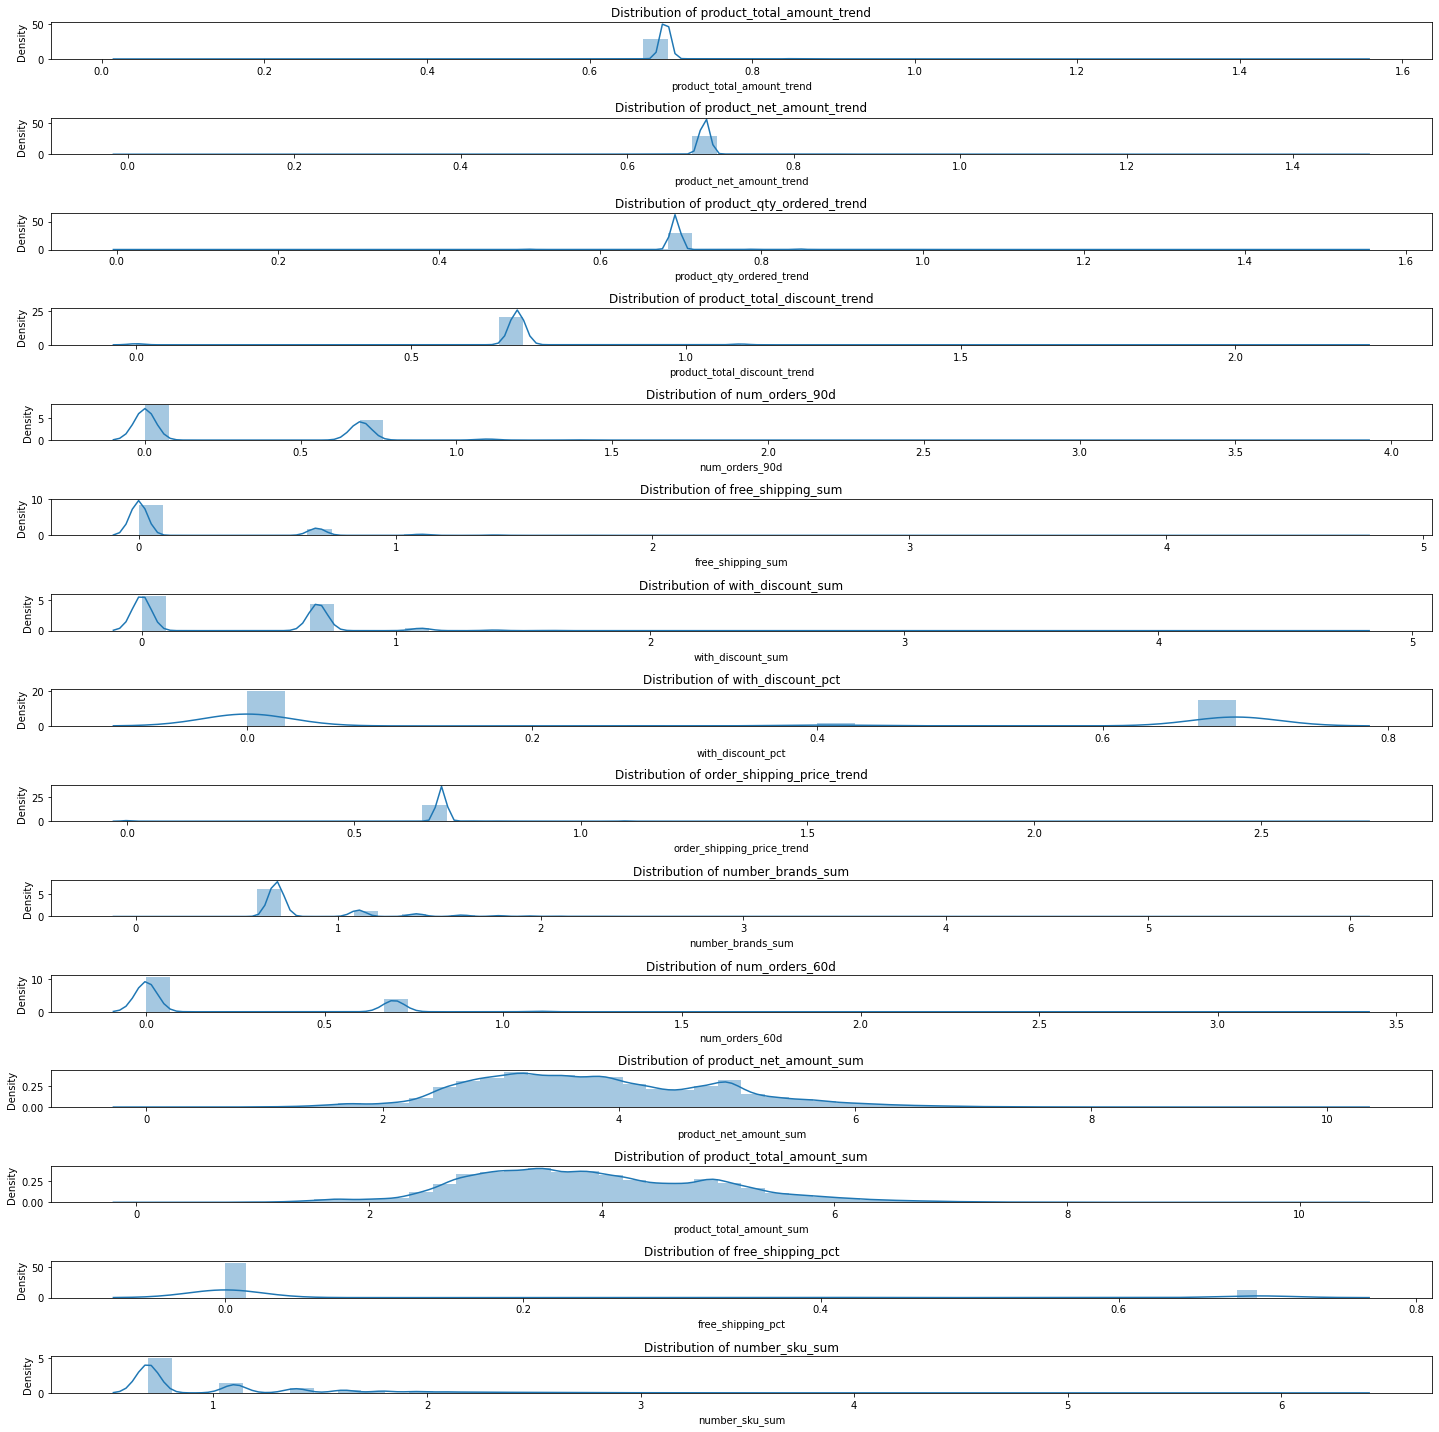

In [176]:
#Removing Skewness
df_features_1y_log = np.log(df_features_1y[['product_total_amount_trend','product_net_amount_trend','product_qty_ordered_trend',\
                  'product_total_discount_trend','num_orders_90d','free_shipping_sum','with_discount_sum',\
                  'with_discount_pct','order_shipping_price_trend','number_brands_sum','num_orders_60d',\
                  'product_net_amount_sum','product_total_amount_sum','free_shipping_pct','number_sku_sum']]+1)

plt.figure (figsize=(20,20))

#product_total_amount_trend
plt.subplot(15,1,1)
check_skew(df_features_1y_log, 'product_total_amount_trend')

#product_net_amount_trend
plt.subplot(15,1,2)
check_skew(df_features_1y_log, 'product_net_amount_trend')

#product_qty_ordered_trend
plt.subplot(15,1,3)
check_skew(df_features_1y_log, 'product_qty_ordered_trend')

#product_total_discount_trend
plt.subplot(15,1,4)
check_skew(df_features_1y_log, 'product_total_discount_trend')

#num_orders_90d
plt.subplot(15,1,5)
check_skew(df_features_1y_log, 'num_orders_90d')

#free_shipping_sum
plt.subplot(15,1,6)
check_skew(df_features_1y_log, 'free_shipping_sum')

#with_discount_sum
plt.subplot(15,1,7)
check_skew(df_features_1y_log, 'with_discount_sum')

#with_discount_pct
plt.subplot(15,1,8)
check_skew(df_features_1y_log, 'with_discount_pct')

#order_shipping_price_trend
plt.subplot(15,1,9)
check_skew(df_features_1y_log, 'order_shipping_price_trend')

#number_brands_sum
plt.subplot(15,1,10)
check_skew(df_features_1y_log, 'number_brands_sum')

#num_orders_60d
plt.subplot(15,1,11)
check_skew(df_features_1y_log, 'num_orders_60d')

#product_net_amount_sum
plt.subplot(15,1,12)
check_skew(df_features_1y_log, 'product_net_amount_sum')

#product_total_amount_sum
plt.subplot(15,1,13)
check_skew(df_features_1y_log, 'product_total_amount_sum')

#free_shipping_pct
plt.subplot(15,1,14)
check_skew(df_features_1y_log, 'free_shipping_pct')

#number_sku_sum
plt.subplot(15,1,15)
check_skew(df_features_1y_log, 'number_sku_sum')

plt.tight_layout()

**Scaling** is important to **uniform** the data with same distance scale, `K-Means` might not form meaningful cluster, because the algorithm is based on the `euclidean-distance` between data points.

In [181]:
scaler = StandardScaler()
scaler.fit(df_features_1y_log)
Wrapper_Features_scaled_1y = scaler.transform(df_features_1y_log)

#dataframe
Wrapper_Features_scaled_1y = pd.DataFrame(Wrapper_Features_scaled_1y, columns=df_features_1y_log.columns)
Wrapper_Features_scaled_1y

product_total_amount_trend  product_net_amount_trend  \
0                        -0.021313                 -0.014464   
1                        -0.021313                 -0.014464   
2                         1.082576                  1.099116   
3                        -0.021313                 -0.014464   
4                        -0.021313                 -0.014464   
...                            ...                       ...   
139541                   -0.021313                 -0.014464   
139542                   -0.021313                 -0.014464   
139543                   -0.021313                 -0.014464   
139544                   -0.021313                 -0.014464   
139545                   -0.153452                 -0.147764   

        product_qty_ordered_trend  product_total_discount_trend  \
0                       -0.032984                      0.041341   
1                       -0.032984                      0.041341   
2                        2.471011                      0.041341   
3                       -0.032984                      0.041341   
4                       -0.032984                      0.041341   
...                           ...                           ...   
139541                  -0.032984                      0.041341   
139542                  -0.032984                      0.041341   
139543                  -0.032984                      0.041341   
139544                  -0.032984                      0.041341   
139545                  -0.517910                      0.041341   

        num_orders_90d  free_shipping_sum  with_discount_sum  \
0            -0.771518          -0.474879          -0.878140   
1             1.152213          -0.474879           0.869549   
2            -0.771518           2.653377          -0.878140   
3             1.152213          -0.474879          -0.878140   
4            -0.771518          -0.474879           0.869549   
...                ...                ...                ...   
139541        1.152213          -0.474879          -0.878140   
139542       -0.771518          -0.474879          -0.878140   
139543       -0.771518           1.498831           0.869549   
139544        1.152213           1.498831           0.869549   
139545        2.277523           3.472540          -0.878140   

        with_discount_pct  order_shipping_price_trend  number_brands_sum  \
0               -0.908440                    0.061243          -0.498568   
1                1.167709                    0.061243           1.249733   
2               -0.908440                   -6.281321           2.661233   
3               -0.908440                    0.061243          -0.498568   
4                1.167709                    0.061243          -0.498568   
...                   ...                         ...                ...   
139541          -0.908440                    0.061243          -0.498568   
139542          -0.908440                    0.061243          -0.498568   
139543           1.167709                    0.061243           1.812561   
139544           1.167709                    0.061243           0.524123   
139545          -0.908440                   -6.281321           1.812561   

        num_orders_60d  product_net_amount_sum  product_total_amount_sum  \
0            -0.618194                0.359678                  0.244064   
1             1.501965               -0.119261                  0.054421   
2            -0.618194                1.772733                  1.640505   
3             1.501965               -0.787183                 -0.889313   
4            -0.618194               -0.981896                 -0.821766   
...                ...                     ...                       ...   
139541        1.501965               -1.102259                 -1.200685   
139542       -0.618194               -2.527296                 -2.608968   
139543       -0.618194                1.562226                  1.47

#### Define K

In [178]:
from scipy.spatial.distance import cdist
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(1,10) 
  
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(Wrapper_Features_scaled_1y) 
    kmeanModel.fit(Wrapper_Features_scaled_1y)     
      
    distortions.append(sum(np.min(cdist(Wrapper_Features_scaled_1y, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / Wrapper_Features_scaled_1y.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(Wrapper_Features_scaled_1y, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / Wrapper_Features_scaled_1y.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 

`Inertia` is the sum of squared distances of samples to their closest cluster centre.

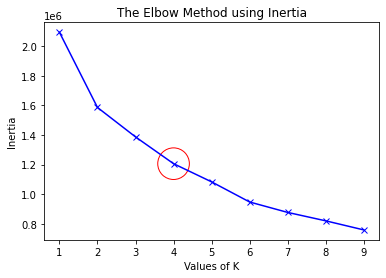

In [182]:
plt.plot(K, inertias, 'bx-')
plt.scatter( 4 ,  1206575.777032101 , s=1000 ,  facecolors='none', edgecolors='red' ) 
plt.xlabel('Values of K') 
plt.ylabel('Inertia') 
plt.title('The Elbow Method using Inertia') 
plt.show() 

In [183]:
mapping2

{1: 2093190.0000000051,
 2: 1585874.0418175978,
 3: 1387262.6986443596,
 4: 1206575.777032101,
 5: 1083947.256485862,
 6: 948053.6475332716,
 7: 877809.0873070938,
 8: 821073.3649709777,
 9: 759814.8510122605}

### Visualize Clusters

#### 2D Plot

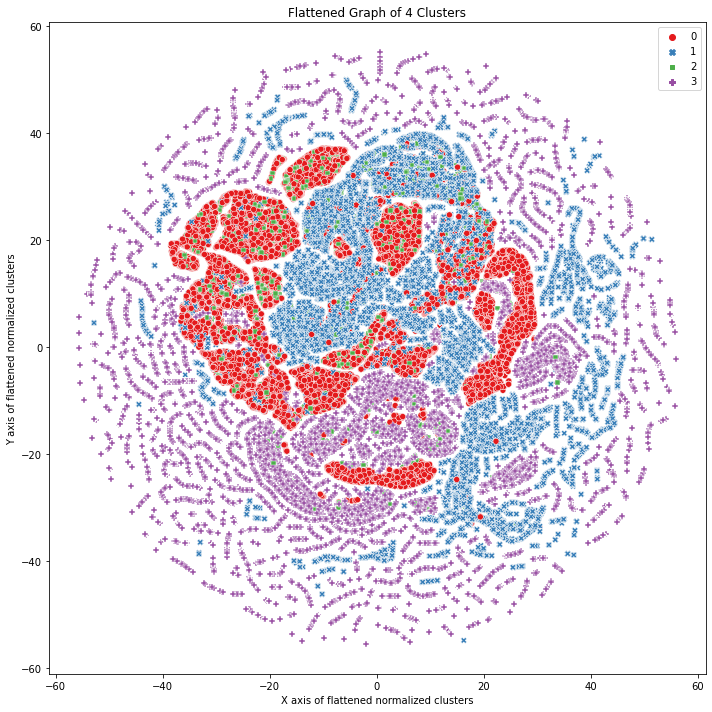

In [184]:
original_df = df_features_1y[['product_total_amount_trend','product_net_amount_trend','product_qty_ordered_trend',\
                  'product_total_discount_trend','num_orders_90d','free_shipping_sum','with_discount_sum',\
                  'with_discount_pct','order_shipping_price_trend','number_brands_sum','num_orders_60d',\
                  'product_net_amount_sum','product_total_amount_sum','free_shipping_pct','number_sku_sum']]

def kmeans(normalised_df_rfm, clusters_number, original_df_rfm):
    
    kmeans = KMeans(n_clusters = clusters_number, random_state = 1)
    kmeans.fit(normalised_df_rfm)

    # Extract cluster labels
    cluster_labels = kmeans.labels_
        
    # Create a cluster label column in original dataset
    df_new = original_df_rfm.assign(Cluster = cluster_labels)
    
    # Initialise TSNE
    model = TSNE(random_state=1)
    transformed = model.fit_transform(df_new)
    
    # Plot t-SNE
    plt.title('Flattened Graph of {} Clusters'.format(clusters_number))
    sns.scatterplot(x=transformed[:,0], y=transformed[:,1], hue=cluster_labels, style=cluster_labels, palette="Set1")
    plt.xlabel('X axis of flattened normalized clusters')
    plt.ylabel('Y axis of flattened normalized clusters')
    return df_new



plt.figure(figsize=(10, 10))
df_wrapper_k4_1y = kmeans(Wrapper_Features_scaled_1y, 4, original_df)
plt.tight_layout()

#### Snake Plot

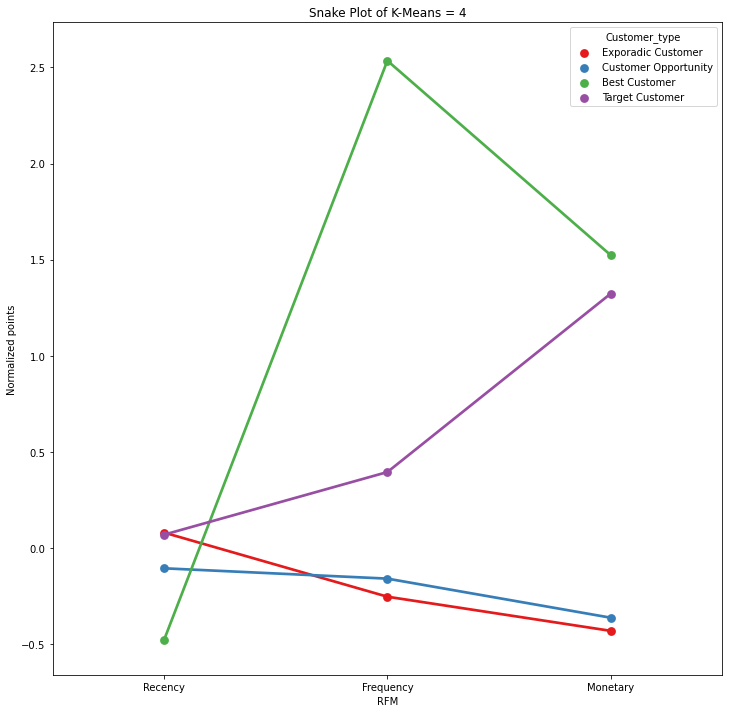

In [202]:
#Create Dataset to Analyse the data
df_analysis=pd.merge(df_1y,df_wrapper_k4_1y, right_index=True, left_index=True)
df_analysis = df_analysis[['CustomerUniqueIdEmailHash', 'num_orders','product_net_amount_sum_y','days_since_last_buy','Cluster']]
df_analysis.rename(columns ={'num_orders':'Frequency','product_net_amount_sum_y':'Monetary','days_since_last_buy':'Recency'}, inplace=True)

#Df features
df_features_ana = df_analysis[['CustomerUniqueIdEmailHash','Frequency','Monetary','Recency']]

#df_cluster
df_cluster2 = df_analysis[['Frequency','Monetary','Recency','Cluster']]

#Scaled dataset
normalize2= df_analysis[['Frequency','Monetary','Recency']]
#Removing skewness
df_hie_log_ana = np.log(normalize2+1)
# Normalizing
scaler = StandardScaler()
scaler.fit(df_hie_log_ana)
Hie_scaled_ana = scaler.transform(df_hie_log_ana)
#Dataframe
Hie_scaled_ana = pd.DataFrame(Hie_scaled_ana, columns=normalize2.columns)

#df
df_cluster2['Customer_type'] = df_cluster2['Cluster']
df_cluster2['Customer_type'].replace({1:'Customer Opportunity',2:'Best Customer',0:'Target Customer',3:'Exporadic Customer'}, inplace=True)

def snake_plot(normalised_df_rfm, df_rfm_kmeans, df_rfm_original):
    normalised_df_rfm = pd.DataFrame(normalised_df_rfm, 
                                       index=df_rfm_original.index, 
                                       columns=df_rfm_original.columns)
    normalised_df_rfm['Customer_type'] = df_rfm_kmeans['Customer_type']

    # Melt data into long format
    df_melt = pd.melt(normalised_df_rfm.reset_index(), 
                        id_vars=['CustomerUniqueIdEmailHash', 'Customer_type'],
                        value_vars=['Recency','Frequency','Monetary'], 
                        var_name='RFM', 
                        value_name='Normalized points')

    plt.xlabel('RFM')
    plt.ylabel('Normalized points')
    sns.pointplot(data=df_melt, x='RFM', y='Normalized points', hue='Customer_type', errwidth=0, palette='Set1') 
    return

plt.figure(figsize=(12, 12))
plt.title('Snake Plot of K-Means = 4')
snake_plot(Hie_scaled_ana, df_cluster2, df_features_ana)

#### Interpretation

In [191]:
def rfm_values(df):

    df_new = df.groupby(['Customer_type','Cluster']).agg({
        'Recency': ['mean','median'],
        'Frequency': ['mean','median'],
        'Monetary': ['mean','median','count']
    }).round(2)
    
    return df_new

rfm_values(df_cluster)

Recency        Frequency        Monetary          \
                                mean median      mean median     mean  median   
Customer_type        Cluster                                                    
Best Customer        2         96.99     69      2.94      2   327.47  210.99   
Customer Opportunity 1        143.16    124      1.10      1    38.49   29.25   
Exporadic Customer   3        148.96    132      1.05      1    36.61   28.26   
Target Customer      0        156.82    152      1.50      1   221.58  149.70   

                                     
                              count  
Customer_type        Cluster         
Best Customer        2         4854  
Customer Opportunity 1        44407  
Exporadic Customer   3        63179  
Target Customer      0        27106

#### Evaluation

In [193]:
# Data Frame
df_fea_1y = df_cluster
df_fea_1y = pd.merge(df_1y,df_cluster, right_index=True, left_index=True)
df_fea_1y = df_fea_1y[['CustomerUniqueIdEmailHash','Frequency', 'Monetary', 'Recency', 'Cluster','Customer_type']]
df_fea_1y

CustomerUniqueIdEmailHash  Frequency  Monetary  \
0       0000179956ad470b814e96c6c9f47b0faefcf4b0          1     64.72   
1       00029736b495db897a94099c5378a6c0ac76e288          1     39.03   
2       00031ac41eb5b21be5b4fbc1d50dd43948e01357          3    282.76   
3       00035cffce191437bd00adea61d73a346b3965d5          1     19.05   
4       0003816b0a2a45fd62432a602f73485e5e6a6c2d          1     15.39   
...                                          ...        ...       ...   
139541  fffdaf75cbff98b85a4c53a3866900ba4bf1d9dd          1     13.47   
139542  fffdb706d9f994e5732b6dd85bc4b181a5d3cda1          1      2.31   
139543  fffdb9bcceac96a27529fb2b46a6a4f9c0b7c5c6          1    227.20   
139544  fffe3332824df69941cd74912548aeb74c10c9cf          1    129.90   
139545  fffe603af1b9d46985202f19d85730fb93af827d          4    706.83   

        Recency  Cluster         Customer_type  
0           326        3    Exporadic Customer  
1             7        1  Customer Opportunity  
2            90        2         Best Customer  
3             8        3    Exporadic Customer  
4           195        1  Customer Opportunity  
...         ...      ...                   ...  
139541       48        3    Exporadic Customer  
139542      152        3    Exporadic Customer  
139543      126        0       Target Customer  
139544       32        0       Target Customer  
139545       20        0       Target Customer  

[139546 rows x 6 columns]

#### 3D Plot - Standard Dataset

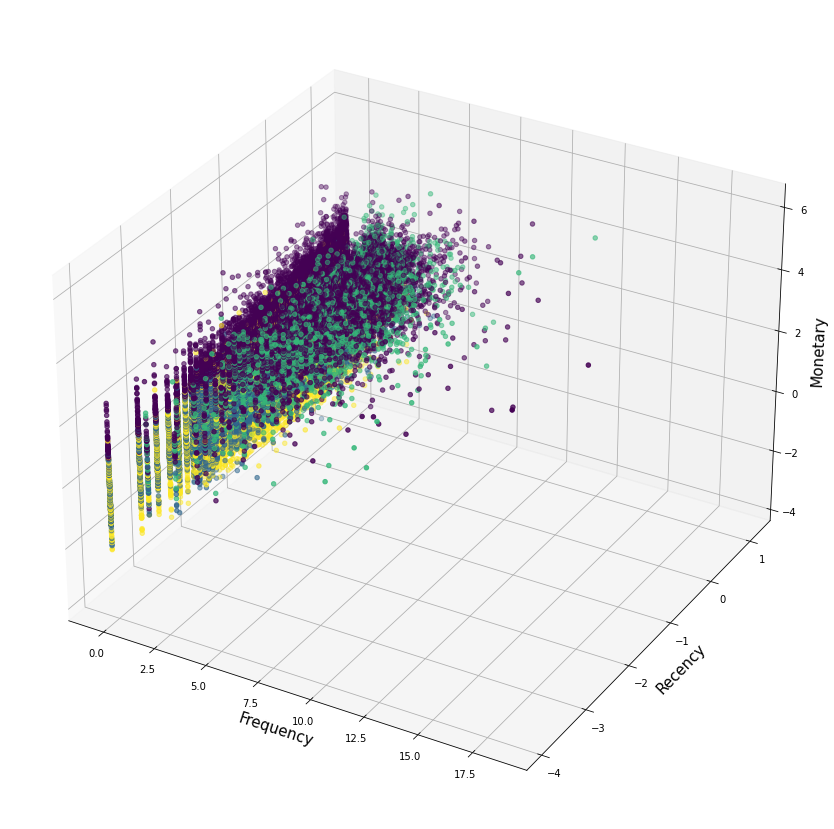

In [194]:
#log
df_fea_1y_log = np.log(df_fea_1y[['Frequency','Monetary','Recency']]+1)

#Standard
scaler = StandardScaler()
scaler.fit(df_fea_1y_log)
df_fea_1y_scaled = scaler.transform(df_fea_1y_log)

#dataframe
df_fea_1y_scaled = pd.DataFrame(df_fea_1y_scaled, columns=df_fea_1y_log.columns)

#merge
merge = df_fea_1y[['CustomerUniqueIdEmailHash','Cluster','Customer_type']]
df_fea_1y_scaled = pd.merge(merge,df_fea_1y_scaled,left_index=True, right_index=True)

#size
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')

# Data for three-dimensional scattered points
zdata =  df_fea_1y_scaled['Monetary']
xdata = df_fea_1y_scaled['Frequency']
ydata = df_fea_1y_scaled['Recency']

ax.scatter3D(xdata, ydata, zdata, c=df_fea_1y_scaled['Cluster'])



ax.set_xlabel('Frequency',fontsize=15)
ax.set_ylabel('Recency',fontsize=15)
ax.set_zlabel('Monetary',fontsize=15)

plt.show()

## Which is the best result ?

#### K-Means RFM 6 months

In [196]:
df_6m['Customer_type'].value_counts(normalize=True)*100

Exporadic Customer      40.678387
Targ et Customer        30.441058
Customer Opportunity    19.537646
Best Customer            9.342909
Name: Customer_type, dtype: float64

#### K-Means RFM 1 year

In [197]:
df_12m['Customer_type'].value_counts(normalize=True)*100

Exporadic Customer      38.995743
Target Customer         28.750376
Customer Opportunity    19.696014
Best Customer           12.557866
Name: Customer_type, dtype: float64

#### K-Means  Filter Feature Method 6 Months

In [198]:
df_fea_6m['Customer_type'].value_counts(normalize=True)*100

Exporadic Customer      50.128957
Customer Opportunity    29.519426
Target Customer         17.564242
Best Customer            2.787374
Name: Customer_type, dtype: float64

#### K-Means  Filter Feature Method 1 year

In [199]:
df_fea_1y['Customer_type'].value_counts(normalize=True)*100

Exporadic Customer      45.274676
Customer Opportunity    31.822481
Target Customer         19.424419
Best Customer            3.478423
Name: Customer_type, dtype: float64

### Silhouette Coefficient

Silhouette Coefficient or silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.

- **1:** Means clusters are well apart from each other and clearly distinguished.

- **0:** Means clusters are indifferent, or we can say that the distance between clusters is not significant.

- **-1:** Means clusters are assigned in the wrong way.


                                            Silhouette Score = (b-a)/max(a,b)

where:

a= average intra-cluster distance i.e the average distance between each point within a cluster.

b= average inter-cluster distance i.e the average distance between all clusters.

Source: https://www.analyticsvidhya.com/blog/2021/05/k-mean-getting-the-optimal-number-of-clusters/

In [209]:
df_rfm_k4 = df_rfm_k4[['Frequency','Recency','Monetary','Cluster']]
df_rfm_k4_1y = df_rfm_k4_1y[['Frequency','Recency','Monetary','Cluster']]
df_cluster = df_cluster[['Frequency','Recency','Monetary','Cluster']]
df_cluster2 = df_cluster2[['Frequency','Recency','Monetary','Cluster']]

#metric
rfm_6m = metrics.silhouette_score(df_rfm_k4,df_rfm_k4['Cluster'])
rfm_1y = metrics.silhouette_score(df_rfm_k4_1y,df_rfm_k4_1y['Cluster'])
wrapper_6m = metrics.silhouette_score(df_cluster,df_cluster['Cluster'])
wrapper_1y = metrics.silhouette_score(df_cluster2,df_cluster2['Cluster'])

#silhoutte
silhoutte_scores = [['RFM 6 months','RFM 1 year',' Filter Feature Method 6 Months',' Filter Feature Method 1 year'],[rfm_6m,rfm_1y,wrapper_6m,wrapper_1y]]
scores = pd.DataFrame(silhoutte_scores, index=['methodology', 'silhoutte_scores']).T
scores

methodology silhoutte_scores
0                     RFM 6 months          0.16702
1                       RFM 1 year         0.124522
2   Filter Feature Method 6 Months         0.018158
3     Filter Feature Method 1 year        -0.009378

### Davies-Bouldin

The score is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances. Thus, clusters which are farther apart and less dispersed will result in a better score.

The minimum score is zero, with lower values indicating better clustering.

Source: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.davies_bouldin_score.html

In [213]:
#Evaluation
RFM_bouldin_6m = metrics.davies_bouldin_score(df_rfm_k4,df_rfm_k4['Cluster'])
RFM_bouldin_1y = metrics.davies_bouldin_score(df_rfm_k4_1y,df_rfm_k4_1y['Cluster'])
Feature_Selecting_bouldin_6m = metrics.davies_bouldin_score(df_cluster,df_cluster['Cluster'])
Feature_Selecting_bouldin_1y = metrics.davies_bouldin_score(df_cluster2,df_cluster2['Cluster'])

#Davies-Bouldin
boldin_scores = [['RFM 6 Months','RFM 1 Year','Filter Feature Method 6 Months','Filter Feature Method 1 Year'],[RFM_bouldin_6m,RFM_bouldin_1y,Feature_Selecting_bouldin_6m,Feature_Selecting_bouldin_1y]]
scores = pd.DataFrame(boldin_scores, index=['methodology', 'Davies_Bouldin_Scores']).T
scores

methodology Davies_Bouldin_Scores
0                    RFM 6 Months              1.502734
1                      RFM 1 Year              1.720489
2  Filter Feature Method 6 Months              4.070801
3    Filter Feature Method 1 Year             17.135448